# Advanced Defect/Carrier Concentration Analysis

```{tip}
You can run this notebook interactively through [Google Colab](https://colab.research.google.com/github/SMTG-Bham/doped/blob/develop/examples/fermisolver_tutorial.ipynb) or [Binder](https://mybinder.org/v2/gh/SMTG-Bham/doped/develop?urlpath=tree/examples/fermisolver_tutorial.ipynb) – just click the links!
If running on Colab, then you'll need to run `!pip install doped` in a cell to install the package, and `!git clone https://github.com/SMTG-Bham/doped` to download the example data (and update paths in the code cells accordingly).
```

For advanced analysis of defect/carrier thermodynamics in `doped`, we provide the `FermiSolver` class. This class includes several key features, focusing on easy scanning of defect populations over multiple parameters of interest, such as temperature, chemical potential, "effective" external dopant concentrations, variable defect mobilities/constraints and more. Some particular points of interest are:

- Methods for automatically scanning over a range of given parameters.
- Interpolation between arbitrary points in chemical potential space for generating "Brouwer-like" diagrams.
- Searching and mapping defect concentrations over the full chemical potential stability limits of a material.
- Integration with py-sc-fermi allows for customising concentration constraints for subsets of defects, which can be particularly useful for considering systems where some, but not all, point defects are mobile.

There are two `FermiSolver` backends: `doped` and `py-sc-fermi`. Both provide similar functionality, but the `py-sc-fermi` backend extends what is possible with `doped` through an interface with the [`py_sc_fermi`](https://github.com/bjmorgan/py-sc-fermi) code. This includes some advanced analysis functionality, which we will describe in this notebook. Unless the user specifies which backend they would like, the code will default to `doped` and use `py-sc-fermi` when required.

## CdTe: Defect Concentrations

We'll start by using the familiar binary CdTe example to outline the basic functionality of the `FermiSolver`. Here we will showcase the functionality of `FermiSolver` by creating two instances with the different backends – of course you will likely only need to use one in your research.

In the simplest case, we can initialise ``FermiSolver`` directly from a ``DefectThermodynamics`` object (see the [thermodynamics tutorial](thermodynamics_tutorial.ipynb)), using the already-set ``bulk_dos``, ``chempots`` and ``el_refs`` parameters:

In [1]:
from doped.thermodynamics import FermiSolver
from monty.serialization import loadfn

defect_thermo = loadfn("CdTe/CdTe_LZ_thermo_wout_meta.json.gz")
fs = FermiSolver(defect_thermo)  # doped backend by default

However we can also add or overwrite the bulk DOS and chemical potentials data:

In [2]:
# we need to specify the path to the vasprun.xml(.gz) file
# that was used for the DOS calculation. This is because
# we need to accurately account for the electronic carrier concentrations
# as well as the defect concentrations to determine the Fermi level
vasprun_path = "CdTe/CdTe_prim_k181818_NKRED_2_vasprun.xml.gz"
# note that if we have already loaded our bulk DOS (``bulk_dos``) into the
# DefectThermodynamics object (e.g. with ``get_equilibrium_fermi_level``)
# we don't need to specify and re-parse ``bulk_dos`` below

# the DefectThermodynamics object contains all the information about the
# defect formation energies, degeneracy factors and transition levels.
# It will underpin both the doped and py-sc-fermi solvers
defect_thermo = loadfn("CdTe/CdTe_LZ_thermo_wout_meta.json.gz")

# and the chemical potentials can then be used to specify the
# defect formation energies under different conditions, and act as a parameter
# space we can scan over to interrogate the defect concentrations
chempots = loadfn("CdTe/CdTe_chempots.json")

# initialize the FermiSolver objects. These require information about the
# defect thermodynamics and the electronic structure of the bulk material. The
# chempots argument can be supplied to overwrite any chempots associated with
# the defect thermodynamics object, but regardless chempots must be supplied
fs = FermiSolver(defect_thermodynamics=defect_thermo, bulk_dos=vasprun_path,
                 chempots=chempots, backend="doped")  # default backend
py_fs = FermiSolver(defect_thermodynamics=defect_thermo, bulk_dos=vasprun_path,
                    chempots=chempots, backend="py-sc-fermi")

Once we have the `FermiSolvers`, perhaps the simplest parameter to scan over is the temperature, and we can do so as follows. We will use this as an example to show that the two solvers return the same results for the same input data.

In [3]:
# define a range of temperatures to scan over
import pandas as pd

temperatures = range(300, 1410, 50)  # temperatures to consider, in K
# the scan_temperature method can be used to scan over a range of temperatures
# and generate a DataFrame containing the defect concentrations, carrier concentrations,
# and Fermi levels at each temperature. We can specify the chemical potentials as 
# a limit,
temperature_df = fs.scan_temperature(limit="Cd-rich", temperature_range=temperatures)

# or they can be specified as a dictionary of chemical potentials referenced to the
# elements in the bulk structure
temperature_df_py = py_fs.scan_temperature(  # manually specify Cd-rich chempots
    chempots={'Cd': 0.0, 'Te': -1.2513}, temperature_range=temperatures)

100%|██████████| 23/23 [00:01<00:00, 22.49it/s] 


In [4]:
# this outputs a dataframe of our defect & carrier concentrations at each temperature and chemical potential:
temperature_df.tail()

Concentration (cm^-3)  Temperature (K)  \
Defect                                                     
Te_Cd                      4.151297e+08           1400.0   
Cd_i_Td_Cd2.83             8.359981e+15           1400.0   
Cd_i_Td_Te2.83             9.655787e+16           1400.0   
Te_i_Td_Te2.83_a           1.198971e+12           1400.0   
Te_i_Td_Te2.83_b           1.067428e+06           1400.0   

                  Fermi Level (eV wrt VBM)  Electrons (cm^-3)  Holes (cm^-3)  \
Defect                                                                         
Te_Cd                              1.10229       2.336290e+17   2.168583e+16   
Cd_i_Td_Cd2.83                     1.10229       2.336290e+17   2.168583e+16   
Cd_i_Td_Te2.83                     1.10229       2.336290e+17   2.168583e+16   
Te_i_Td_Te2.83_a                   1.10229       2.336290e+17   2.168583e+16   
Te_i_Td_Te2.83_b                   1.10229       2.336290e+17   2.168583e+16   

                  μ_Cd (eV)  μ_Te (eV)  
Defect                                  
Te_Cd                   0.0  -1.251317  
Cd_i_Td_Cd2.83          0.0  -1.251317  
Cd_i_Td_Te2.83          0.0  -1.251317  
Te_i_Td_Te2.83_a        0.0  -1.251317  
Te_i_Td_Te2.83_b        0.0  -1.251317

Let's plot the results:

In [5]:
import matplotlib.pyplot as plt
import doped

# we can use the doped style file to make all our plots look consistent
plt.style.use(f"{doped.__path__[0]}/utils/doped.mplstyle")  # use doped style

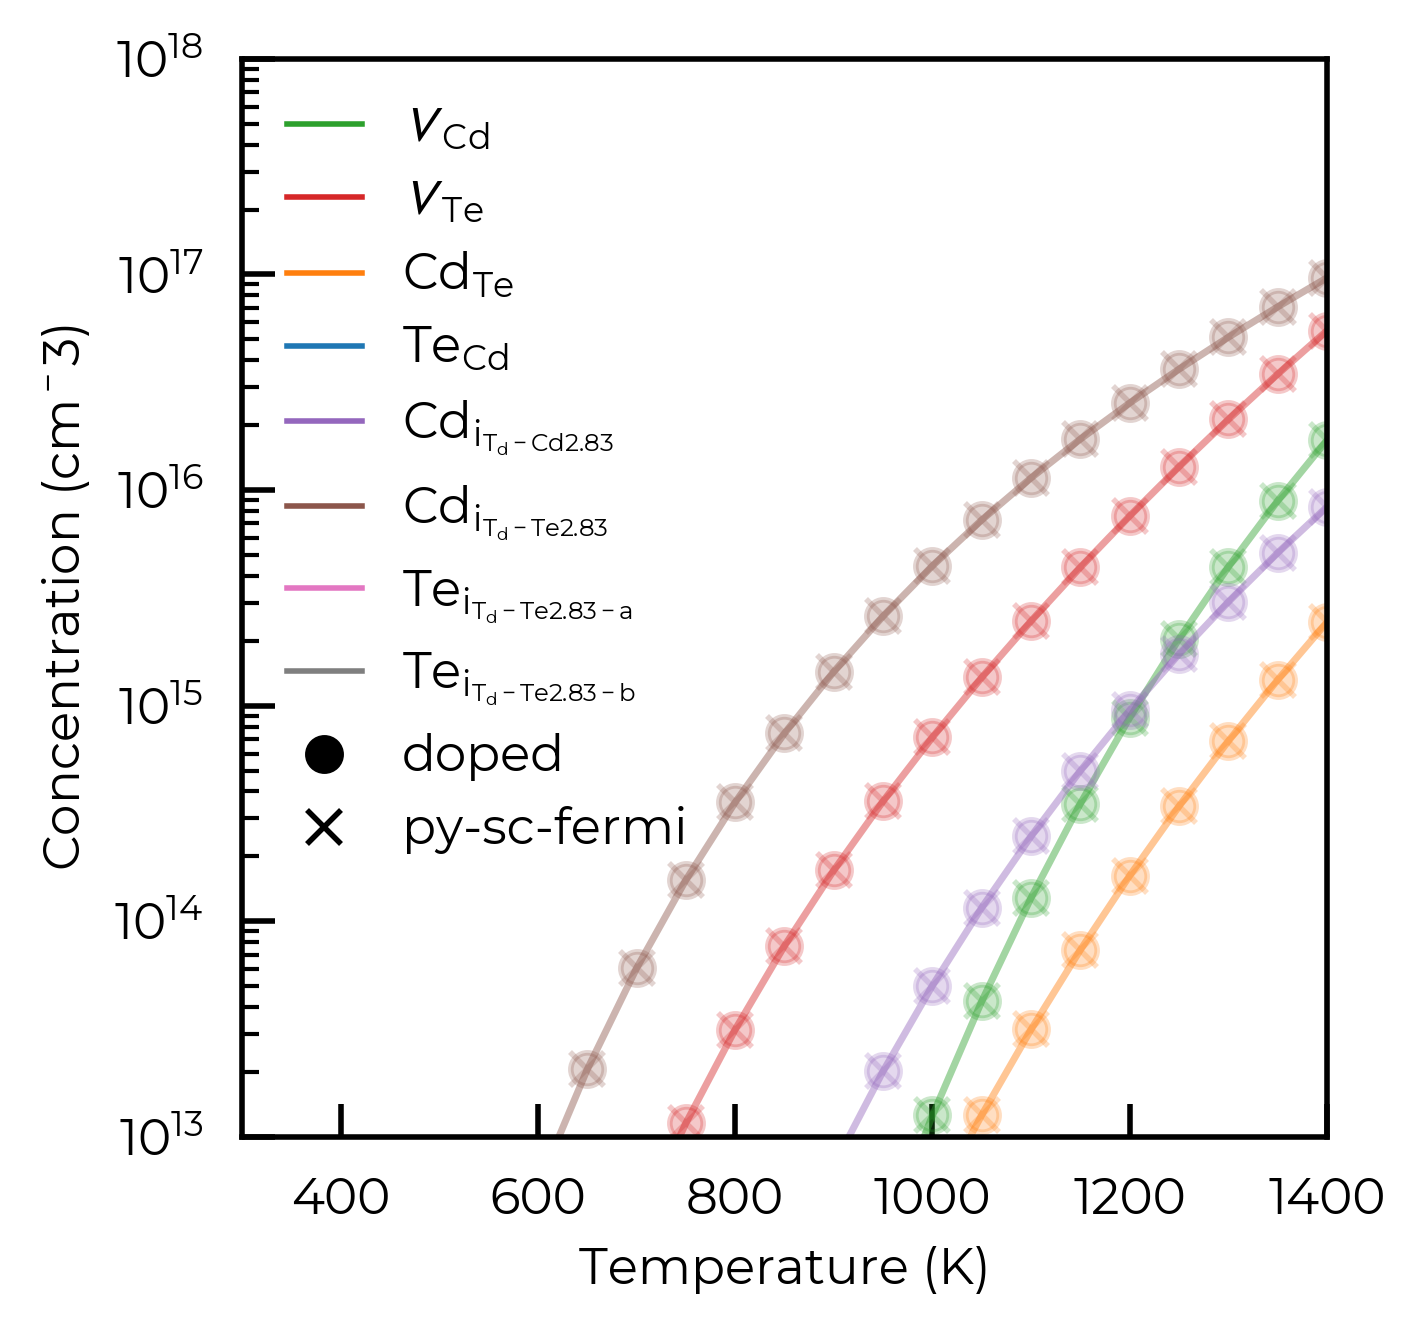

In [8]:
from doped.utils.plotting import format_defect_name
# we can specify the colors to use for each defect, so that the same defect
# is plotted in the same color for both backends, and we keep all our plots consistent
defect_colors = {"Te_Cd": "C0", "Cd_Te": "C1", "v_Cd": "C2", "v_Te": "C3",
                 "Cd_i_Td_Cd2.83": "C4", "Cd_i_Td_Te2.83": "C5", "Te_i_Td_Te2.83_a": "C6",
                 "Te_i_Td_Te2.83_b": "C7"}

# label the results with the backend used to generate them, and concatenate the results
temperature_df["backend"] = "doped"
temperature_df_py["backend"] = "py-sc-fermi"
plot_data = pd.concat([temperature_df, temperature_df_py])

# Create a unique list of defects in the DataFrame
unique_defects = temperature_df.index.unique()

fig, ax = plt.subplots()

# loop over the unique defects and plot the defect concentrations
# as a function of temperature, for both the doped and py-sc-fermi backends
for defect in unique_defects:
    defect_df = plot_data.loc[defect]

    for backend in ["doped", "py-sc-fermi"]:
        defect_df_backend = defect_df[defect_df["backend"] == backend]
        ax.plot(defect_df_backend["Temperature (K)"],
                defect_df_backend["Concentration (cm^-3)"],
                label=format_defect_name(defect, include_site_info_in_name=True, wout_charge=True),
                color=defect_colors[defect],
                marker="o" if backend == "doped" else "x",
                alpha = 0.25)

ax.set_xlabel("Temperature (K)")
ax.set_ylabel("Concentration (cm$^{-3}$)")

ax.set_xlim(300, 1400)
ax.set_ylim(1e13, 1e18)
ax.set_yscale("log")

custom_lines = [plt.Line2D([0], [0], color=defect_colors[defect], lw=1) for defect in unique_defects]
custom_lines.append(plt.Line2D([0], [0], color="black", lw=1, marker="o", linestyle="None", label="doped"))
custom_lines.append(plt.Line2D([0], [0], color="black", lw=1, marker="x", linestyle="None", label="py-sc-fermi"))
ax.legend(custom_lines,
          [f"{format_defect_name(defect, include_site_info_in_name=True, wout_charge=True)}" for defect in unique_defects] + ["doped", "py-sc-fermi"],
          frameon=False)

plt.show()

From the plot above, it is clear that when scanning the temperature, the defect concentrations reported by the two back-ends are essentially identical.

To continue to show the functionality of the `FermiSolver`, we'll show how we can generate a Brouwer-digaram-like figure, with defect concentrations shown as a function of chemical potentials.

These scanning methods (including `scan_temperature`) can accept `annealing_temperatures` and `quenched_temperatures` arguments instead of `temperature`. These will carry out "frozen-defect" calculations between these temperatures as discussed in the [defect thermodynamics tutorial](https://doped.readthedocs.io/en/latest/thermodynamics_tutorial.html).

In this cell, we'll continue to directly compare the results of `py-sc-fermi` and `doped`.

100%|██████████| 20/20 [00:01<00:00, 19.80it/s]


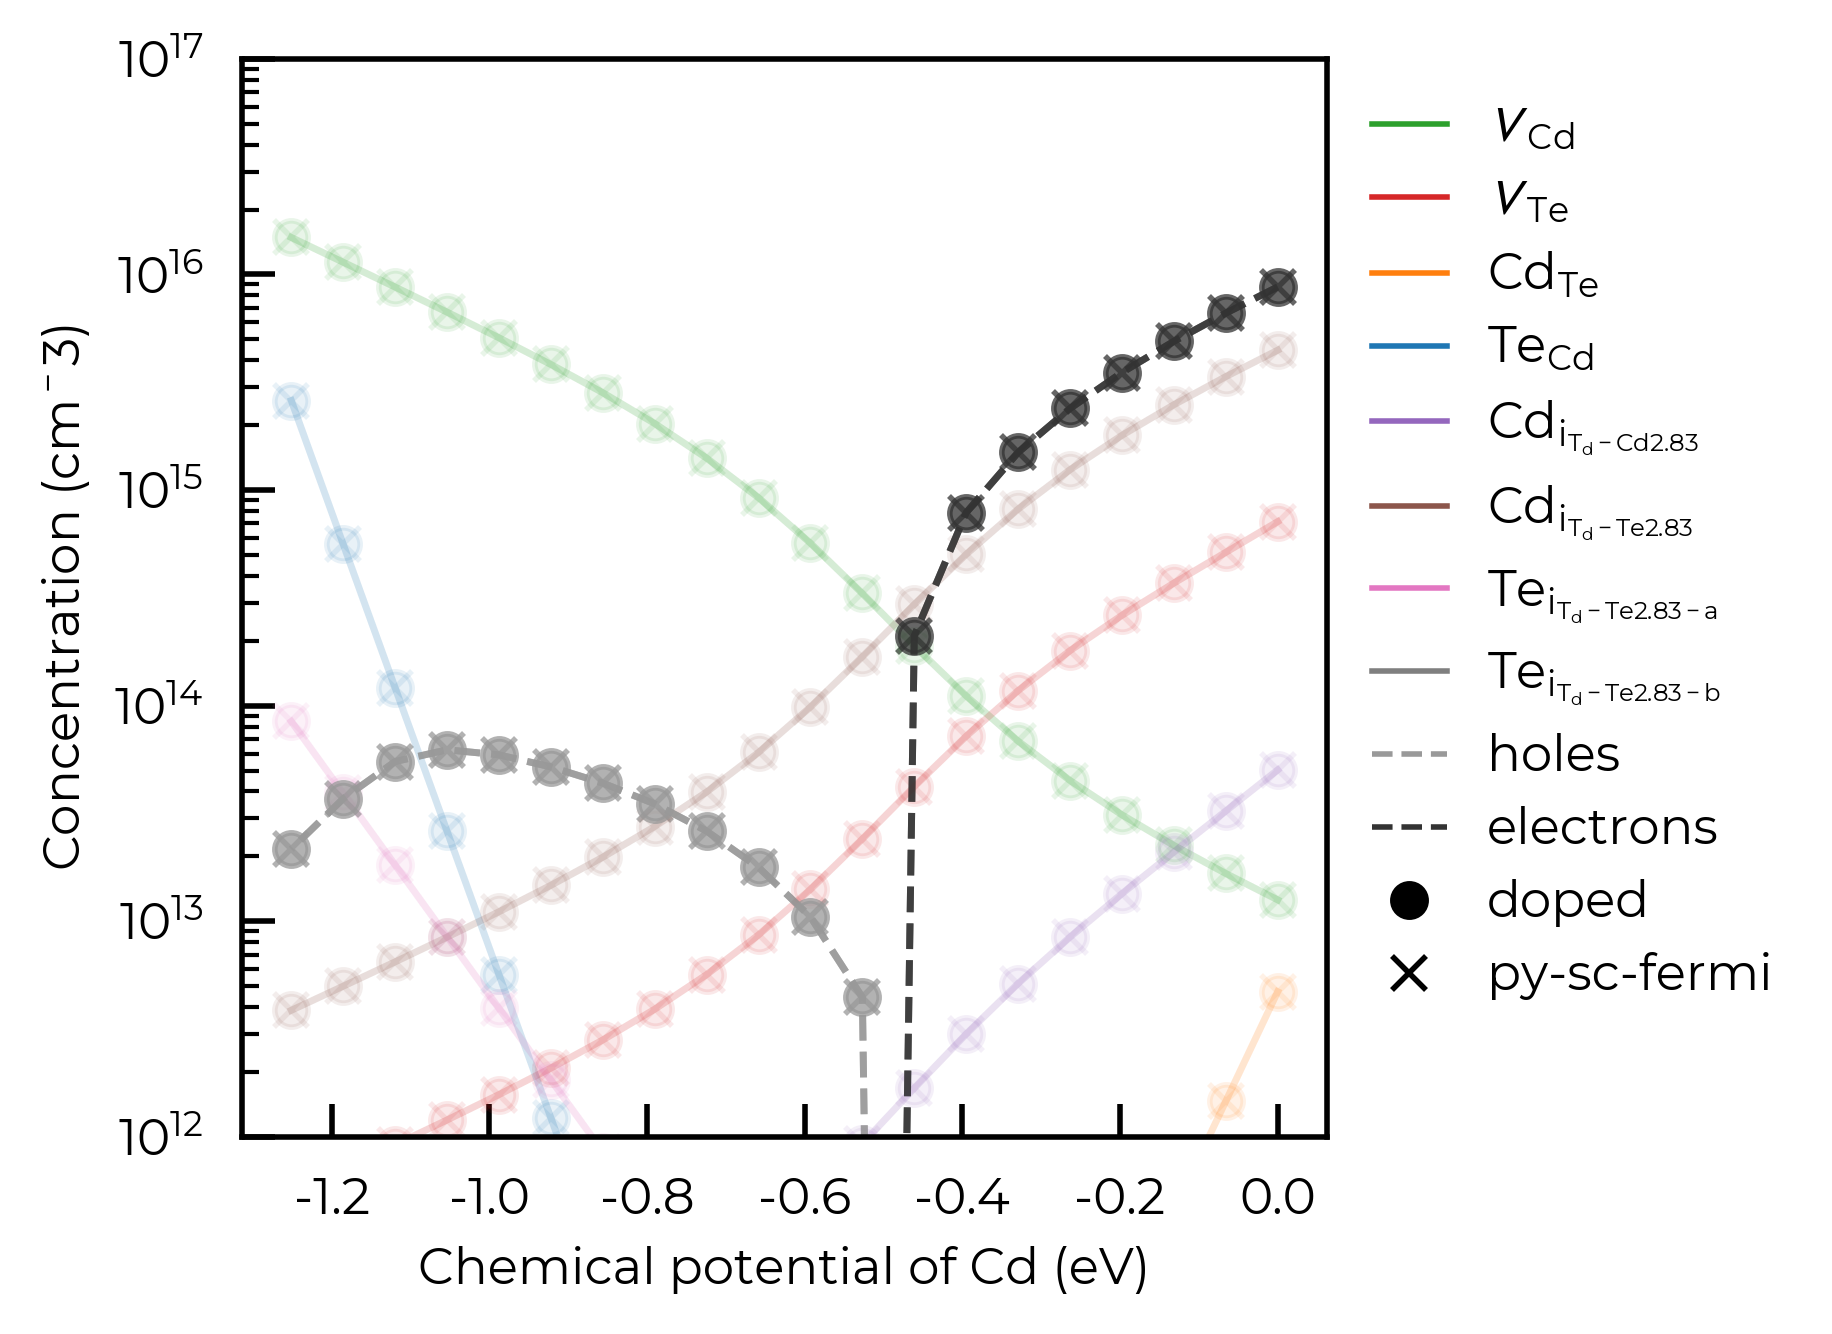

In [10]:
# scan between the Cd and Te rich limits to see how the defect concentrations
# change as a function of chemical potential
mu_df = py_fs.interpolate_chempots(limits = ["Cd-rich", "Te-rich"], 
                                   n_points=20, annealing_temperature=1000, 
                                   quenched_temperature = 300)
mu_df_doped = fs.interpolate_chempots(limits = ["Cd-rich", "Te-rich"],
                                      n_points=20, annealing_temperature=1000,
                                      quenched_temperature=300)

# we'll keep the py-sc-fermi and doped comparison going, especially as we have made
# the solution slightly more complex by introducing the annealing-quenching process.
mu_df["backend"] = "py-sc-fermi"
mu_df_doped["backend"] = "doped"
mu_df = pd.concat([mu_df, mu_df_doped])

fig, ax = plt.subplots()

# loop over the unique defects and plot their defect concentrations as a function
# of the chemical potential of Cd, for both the doped and py-sc-fermi backends
for backend in ["py-sc-fermi", "doped"]:
    for defect in unique_defects:
        defect_df = mu_df.loc[defect]
        defect_df_backend = defect_df[defect_df["backend"] == backend]
        ax.plot(defect_df_backend["μ_Cd (eV)"],
            defect_df_backend["Concentration (cm^-3)"], 
            label=format_defect_name(defect, include_site_info_in_name=True, wout_charge=True), 
            color=defect_colors[defect], 
            marker="o" if backend == "doped" else "x",
            alpha = 0.1)
    ax.plot(defect_df_backend["μ_Cd (eV)"],
            defect_df_backend["Holes (cm^-3)"], 
            marker="o" if backend == "doped" else "x", 
            linestyle="--", 
            alpha = 0.75,
            color = "#999999")
    ax.plot(defect_df_backend["μ_Cd (eV)"],
            defect_df_backend["Electrons (cm^-3)"], 
            marker="o" if backend == "doped" else "x", 
            linestyle="--",
            alpha = 0.75, 
            color = "#333333")

ax.set_xlabel("Chemical potential of Cd (eV)")
ax.set_ylabel("Concentration (cm$^{-3}$)")

# legend formatting
custom_lines = [plt.Line2D([0], [0], color=defect_colors[defect], lw=1) for defect in unique_defects]
custom_lines.append(plt.Line2D([0], [0], color="#999999", lw=1, linestyle="--", label="holes"))
custom_lines.append(plt.Line2D([0], [0], color="#333333", lw=1, linestyle="--", label="electrons"))
custom_lines.append(plt.Line2D([0], [0], color="black", lw=1, marker="o", linestyle="None", label="doped"))
custom_lines.append(plt.Line2D([0], [0], color="black", lw=1, marker="x", linestyle="None", label="py-sc-fermi"))
plt.legend(custom_lines, 
          [f"{format_defect_name(defect, include_site_info_in_name=True, wout_charge=True)}" for defect in unique_defects] + ["holes", "electrons", "doped", "py-sc-fermi"],
          frameon=False, loc="upper left", bbox_to_anchor=(1, 1))
plt.ylim(1e12, 1e17)
plt.yscale("log")
plt.show()

```{tip}
As always, see the [code documentation](https://doped.readthedocs.io/en/latest/) for details on further customisation and control with these functions!
```

## Effective dopant concentrations

In certain cases, we would like to directly simulate the effect of adding a dopant into our system to see how it will change the defect concentrations. If we treat the dopant concentration as an additional free parameter, we can change our charge neutrality condition from

$$ 0 = \sum_{X} q[{X}^q] + [\mathrm{electrons}] + [\mathrm{holes}] $$

to 

$$ 0 = \sum_{X} q[{X}^q] + [\mathrm{electrons}] + [\mathrm{holes}] + r[M^r] $$

where $M$ is the concentration of the dopant with charge $r$. As we are treating this as a free parameter, $r[M^r]$ can be considered as single parameter, an effective dopant concentration that we can additionally scan over when investigating defect concentrations. 

This analysis can be useful for investigating the host defect response to an as-yet-unidentified dopant/impurity; predicting how the Fermi level and defect/carrier concentrations will change in response to a range of possible dopant concentrations. Or in other words, for analysing the dopability and compensation response, which can be useful for investigating potential solar cell / transparent conductor / thermoelectric / battery materials and more. 

See, for example:  
- [Murdock et al. Li-Site Defects Induce Formation of Li-Rich Impurity Phases:
Implications for Charge Distribution and Performance of
LiNi<sub>0.5−x</sub>M<sub>x</sub>Mn<sub>1.5</sub>O<sub>4</sub> Cathodes](https://onlinelibrary.wiley.com/doi/pdfdirect/10.1002/adma.202400343)
- [Squires et al., Native Defects and Their Doping Response in the Lithium Solid Electrolyte Li<sub>7</sub>La<sub>3</sub>Zr<sub>2</sub>O<sub>12</sub>](https://pubs.acs.org/doi/abs/10.1021/acs.chemmater.9b04319)

This can be investigated in `doped` using the `effective_dopant_concentration` parameter in the Fermi level solving functions (both with `DefectThermodynamics` and the `FermiSolver` objects):

100%|██████████| 100/100 [00:02<00:00, 44.16it/s]


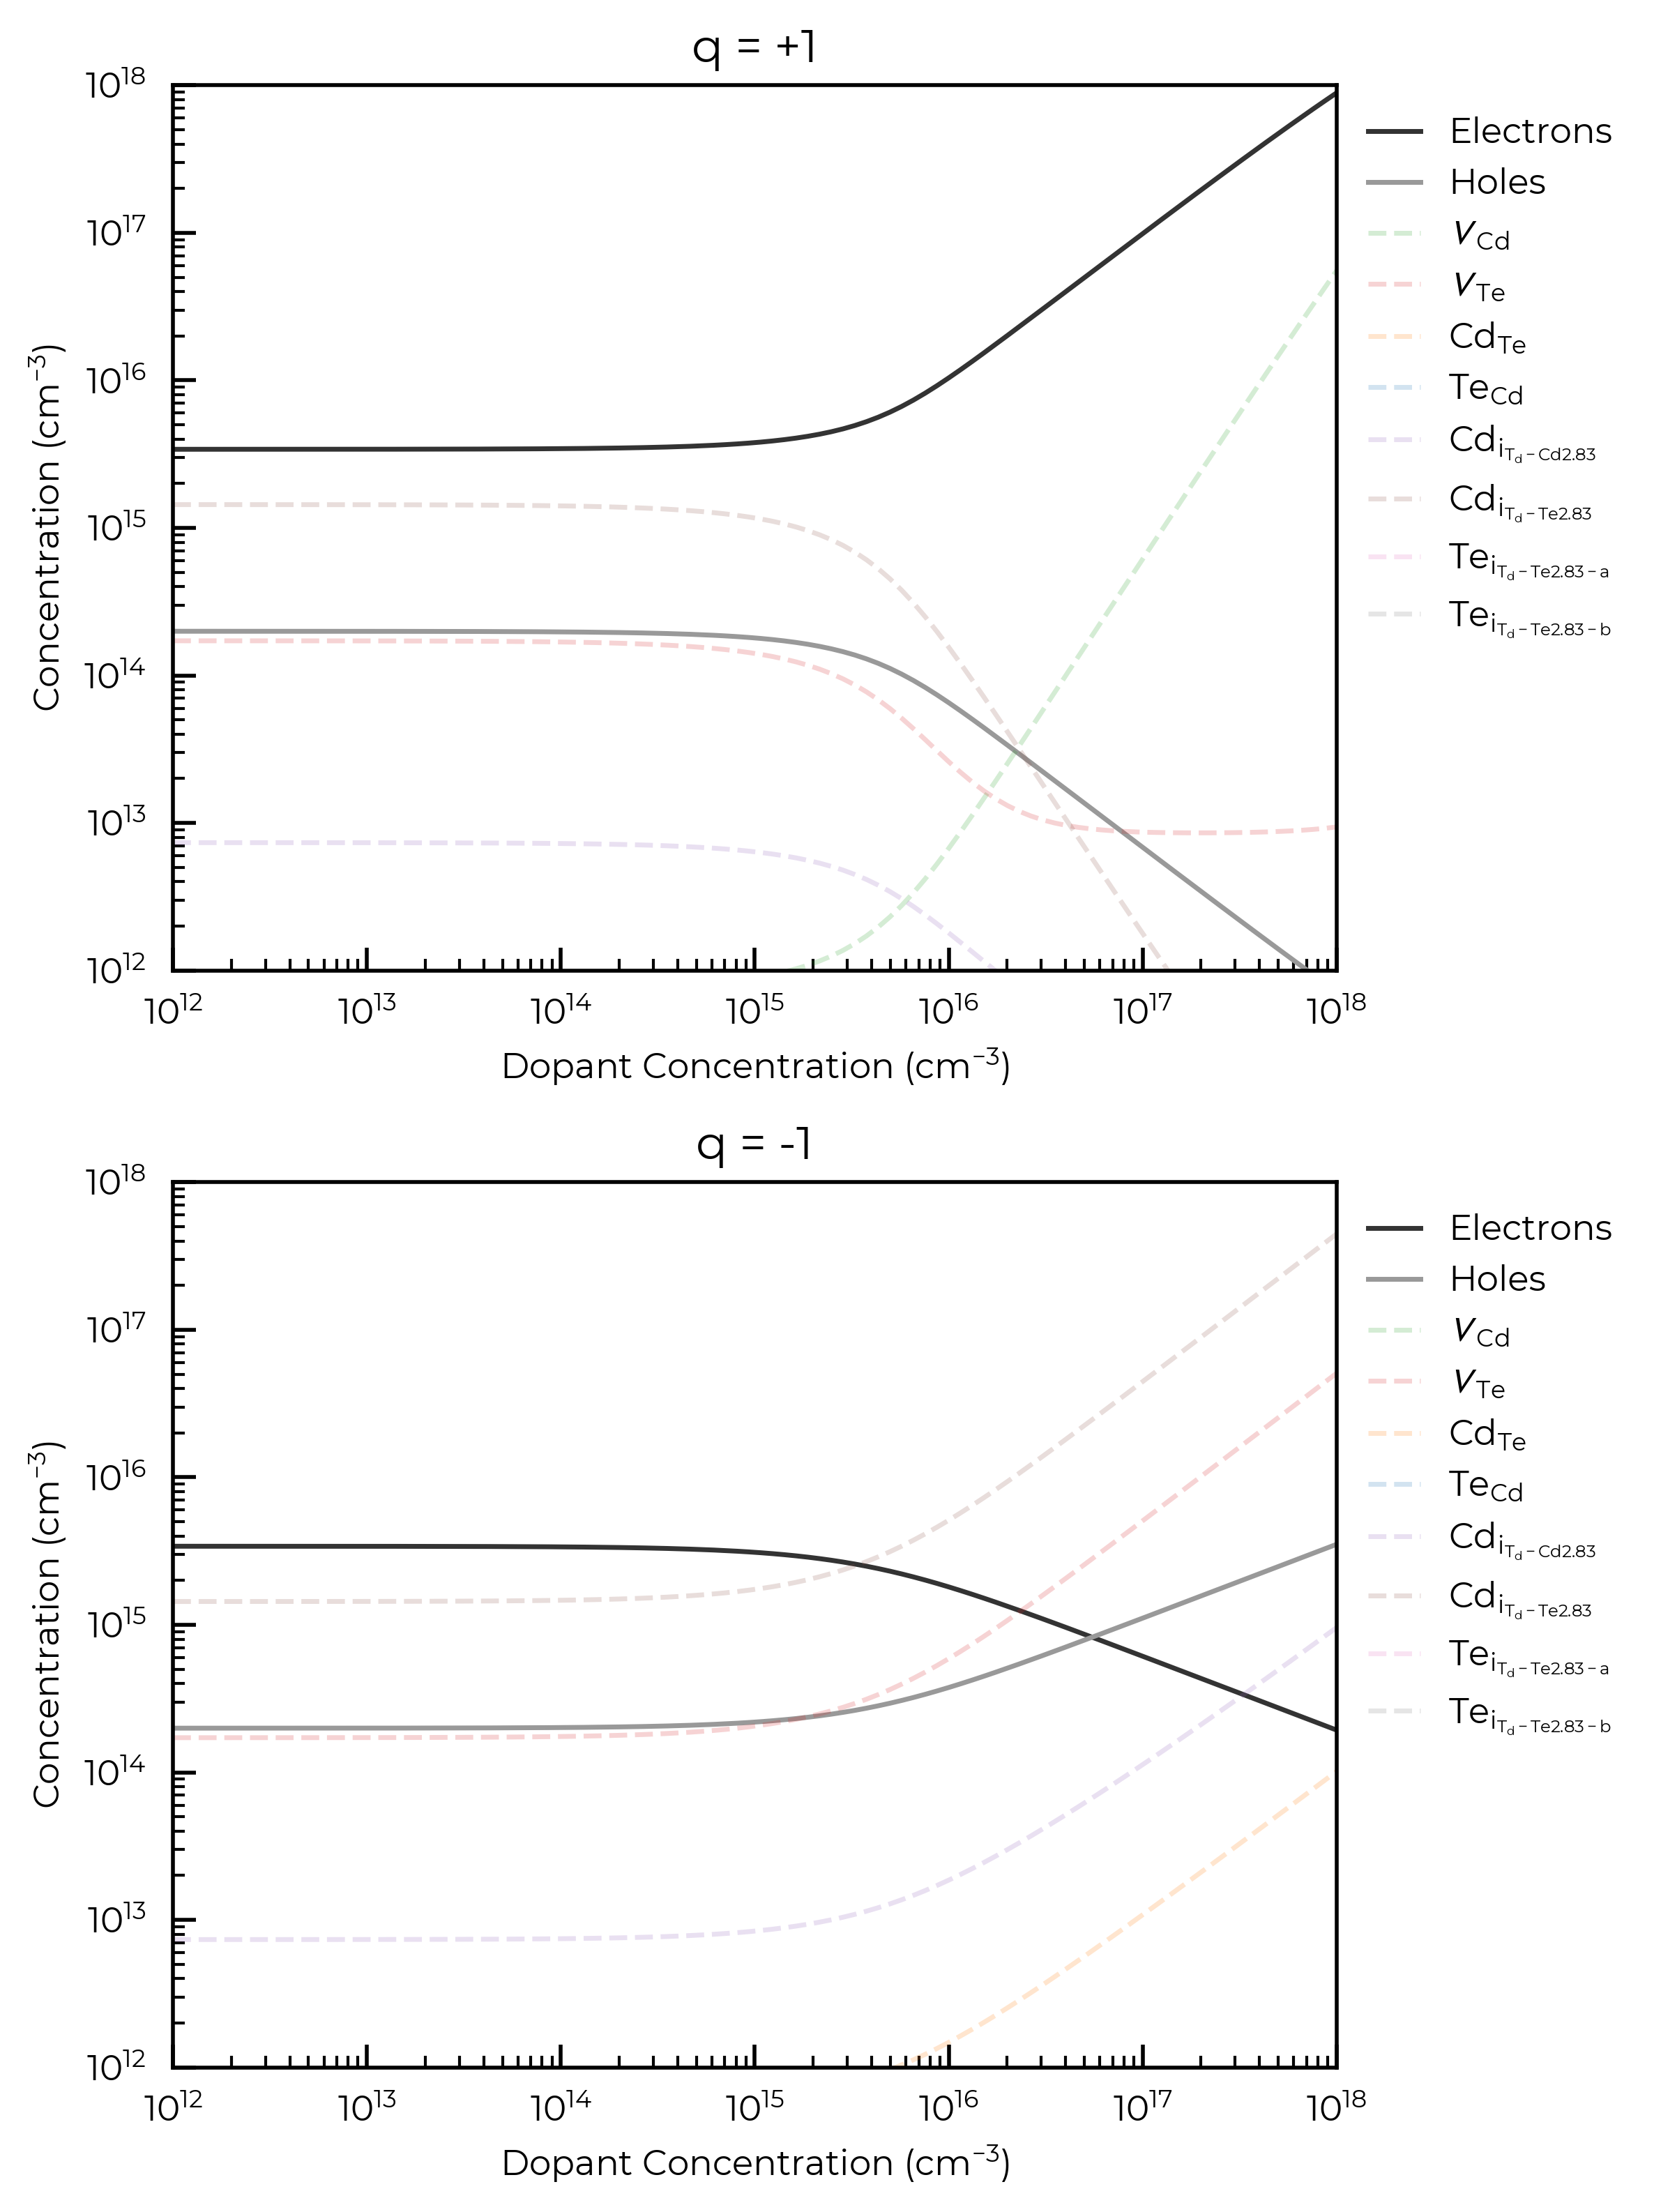

In [11]:
def plot_dopant_data(ax, df, concentrations, defect, color, **kwargs):
    """Simple function to handle the plotting in the following cells"""
    defect_df = df.loc[defect]
    ax.plot(concentrations, defect_df["Concentration (cm^-3)"], 
            label=format_defect_name(defect, include_site_info_in_name=True, wout_charge=True) or "Dopant",
            color=color, alpha=0.2, **kwargs)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("Dopant Concentration (cm$^{-3}$)")
    ax.set_ylabel("Concentration (cm$^{-3}$)")
    ax.legend(frameon=False, loc="upper left", bbox_to_anchor=(1, 1))

def plot_dopant_carrier_concentrations(dopant_df_positive, dopant_df_negative, ax):
    ax[0].plot(dopant_df_positive["Dopant (cm^-3)"], dopant_df_positive["Electrons (cm^-3)"], label="Electrons", color="#333333")
    ax[0].plot(dopant_df_positive["Dopant (cm^-3)"], dopant_df_positive["Holes (cm^-3)"], label="Holes", color="#999999")
    ax[1].plot(-dopant_df_negative["Dopant (cm^-3)"], dopant_df_negative["Electrons (cm^-3)"], label="Electrons", color="#333333")
    ax[1].plot(-dopant_df_negative["Dopant (cm^-3)"], dopant_df_negative["Holes (cm^-3)"], label="Holes", color="#999999")

# scan a positive and negative effective dopant concentration range - note this can 
# be done with both the doped and py-sc-fermi backends. We will just use the doped backend
# for this example.
import numpy as np
dopant_concentrations = np.logspace(12, 18, 100)
defect_colors.update({"Dopant": "gray"})

dopant_df_positive = fs.scan_dopant_concentration(
    chempots={'Cd': 0.0, 'Te': -1.251}, temperature=900,
    effective_dopant_concentration_range=dopant_concentrations)
dopant_df_negative = fs.scan_dopant_concentration(
    chempots={'Cd': 0.0, 'Te': -1.251}, temperature=900,
    effective_dopant_concentration_range=-1*dopant_concentrations)

fig, ax = plt.subplots(2, 1, figsize=(6, 8))
plot_dopant_carrier_concentrations(dopant_df_positive, dopant_df_negative, ax)
for defect in dopant_df_positive.index.unique():
    plot_dopant_data(ax[0], dopant_df_positive, dopant_concentrations, defect, defect_colors[defect], ls="--")
    plot_dopant_data(ax[1], dopant_df_negative, dopant_concentrations, defect, defect_colors[defect], ls="--")

ax[0].set_xlim(1e12, 1e18); ax[1].set_xlim(1e12, 1e18)
ax[0].set_ylim(1e12, 1e18); ax[1].set_ylim(1e12, 1e18)
ax[0].set_title(f"q = +1"); ax[1].set_title(f"q = -1")
plt.tight_layout()
plt.show()

The cell below illustrates the same functionality, but we now have an annealing and quenching temperature, this requires minimal changes to the code. The `plot_data` function from the cell above is used again:

100%|██████████| 100/100 [00:06<00:00, 14.74it/s]


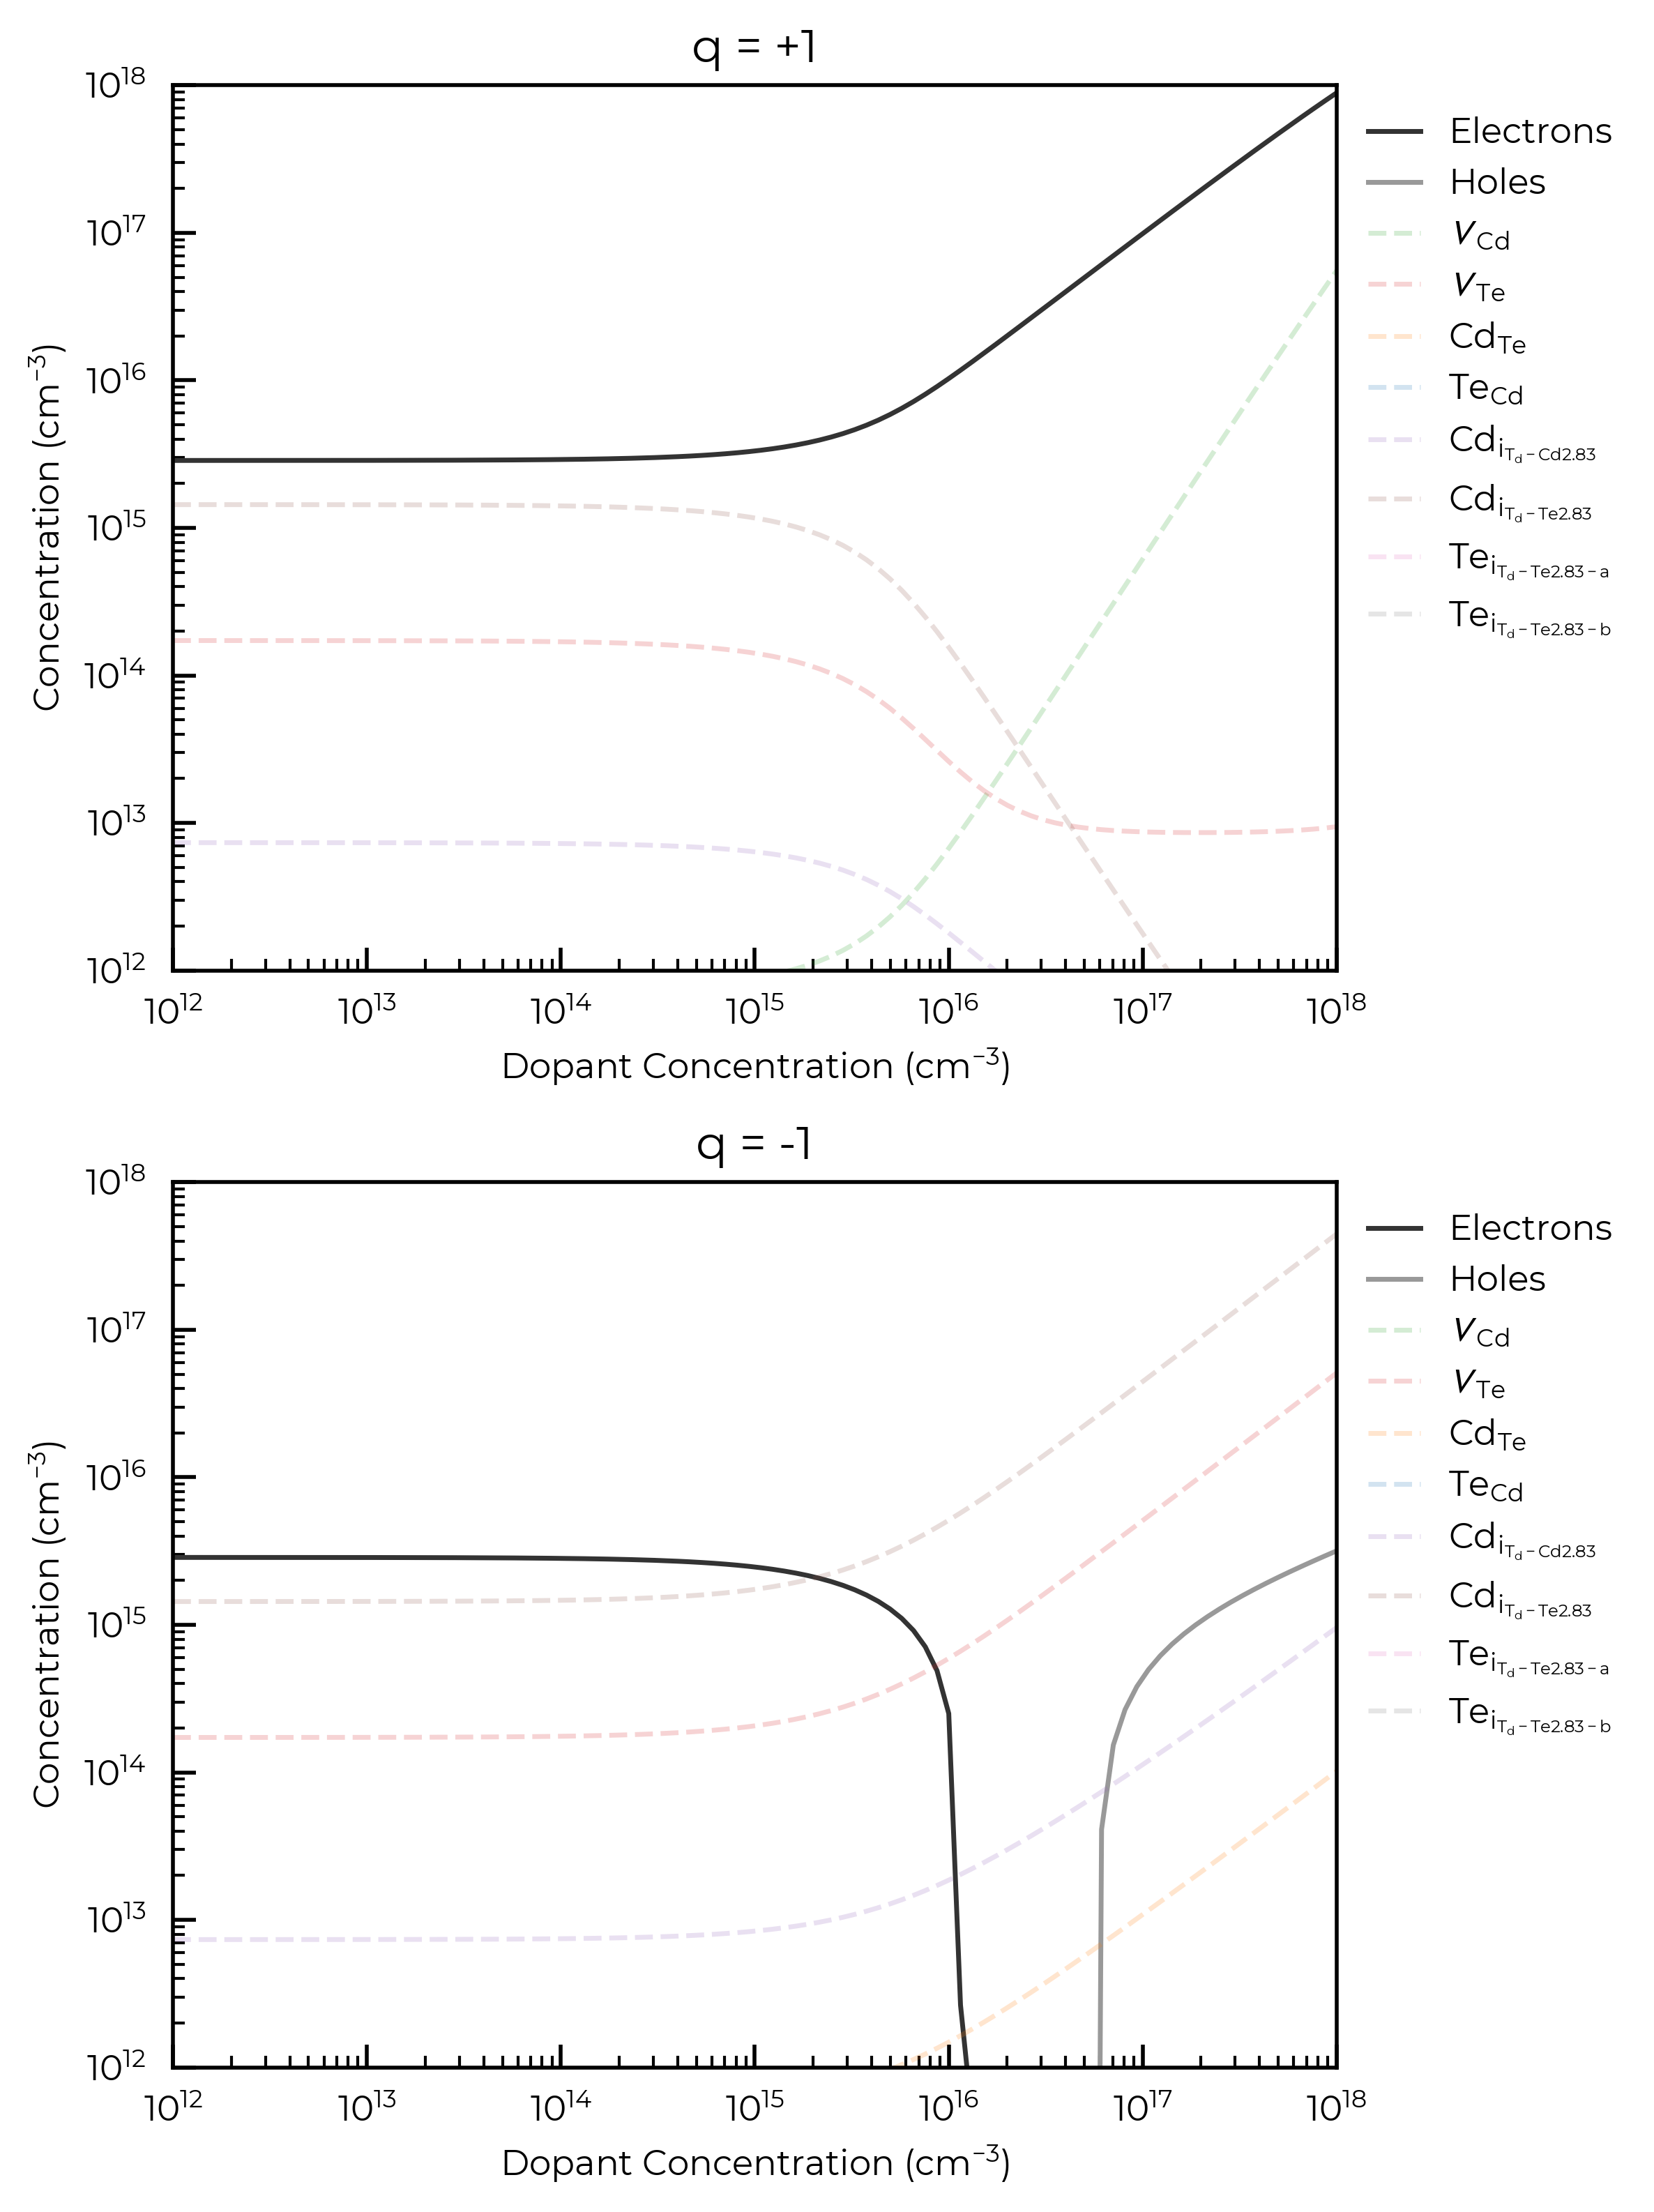

In [12]:
dopant_concentrations = np.logspace(12, 18, 100)
fig, ax = plt.subplots(2, 1, figsize=(6, 8))

# the only difference here is that we're scanning over dopant concentration
# having annealed at 900 K and quenched to 300 K
dopant_df_positive = fs.scan_dopant_concentration(
    chempots=chempots["limits_wrt_el_refs"]["Cd-CdTe"], annealing_temperature = 900,
    quenched_temperature = 300, effective_dopant_concentration_range=dopant_concentrations)
dopant_df_negative = fs.scan_dopant_concentration(
    limit="Cd-rich", quenched_temperature=300, annealing_temperature=900,
    effective_dopant_concentration_range=-dopant_concentrations)

plot_dopant_carrier_concentrations(dopant_df_positive, dopant_df_negative, ax)
for defect in dopant_df_positive.index.unique():
    plot_dopant_data(ax[0], dopant_df_positive, dopant_concentrations, defect, defect_colors[defect], ls="--")
    plot_dopant_data(ax[1], dopant_df_negative, dopant_concentrations, defect, defect_colors[defect], ls="--")
    
ax[0].set_xlim(1e12, 1e18); ax[1].set_xlim(1e12, 1e18)
ax[0].set_ylim(1e12, 1e18); ax[1].set_ylim(1e12, 1e18)
ax[0].set_title(f"q = +1"); ax[1].set_title(f"q = -1")
plt.tight_layout()
plt.show()

For both donor and acceptor dopants here, we see that a concentration $>10^{15}$ cm$^{-3}$ is required to significantly affect the Fermi level and thus carrier and intrinsic defect concentrations, for an annealing temperature of 900 K. This is the point at which the dopant concentration is equivalent to the concentrations of the highest-concentration intrinsic defects in the system and can be thought of as now influencing the Fermi energy "pinning".

## Custom Concentration/Equilibration Constraints

One thing we can do in `py-sc-fermi` is specify defects to be excluded from the 'frozen defect' approximation (i.e. the assumption that the total defect concentration will remain fixed at the high temperature value). This is useful in systems where we expect barriers for some defect recombination to be low. Take the example of an ion conductor, if interstitials of the mobile ion $M$ form at high temperature, it may be unreasonable to assume these defects cannot then move into vacant $M$ sites on cooling. For example, see

- [Squires et al., Low electronic conductivity of Li<sub>7</sub>La<sub>3</sub>Zr<sub>2</sub>O<sub>12</sub> solid electrolytes from first principles](https://journals.aps.org/prmaterials/abstract/10.1103/PhysRevMaterials.6.085401)

To explore these kinds of _what if_ situations, all the quenching & annealing `FermiSolver` methods can accept an additional `free-defects` argument when using the ``"py-sc-fermi"`` backend, which specifies defects that are allowed to fully re-equilibrate at the quenched temperature (i.e. for which the 'frozen defect' approximation is not applied). The cell below shows this hypothetical example where the Te interstitials ([known](https://pubs.rsc.org/en/content/articlelanding/2022/fd/d2fd00043a) to be highly-mobile) and vacancies are allowed to recombine on cooling, but the total concentrations of all other defects remain fixed at the high temperature values ('frozen defect' approximation).

100%|██████████| 100/100 [00:07<00:00, 13.04it/s]


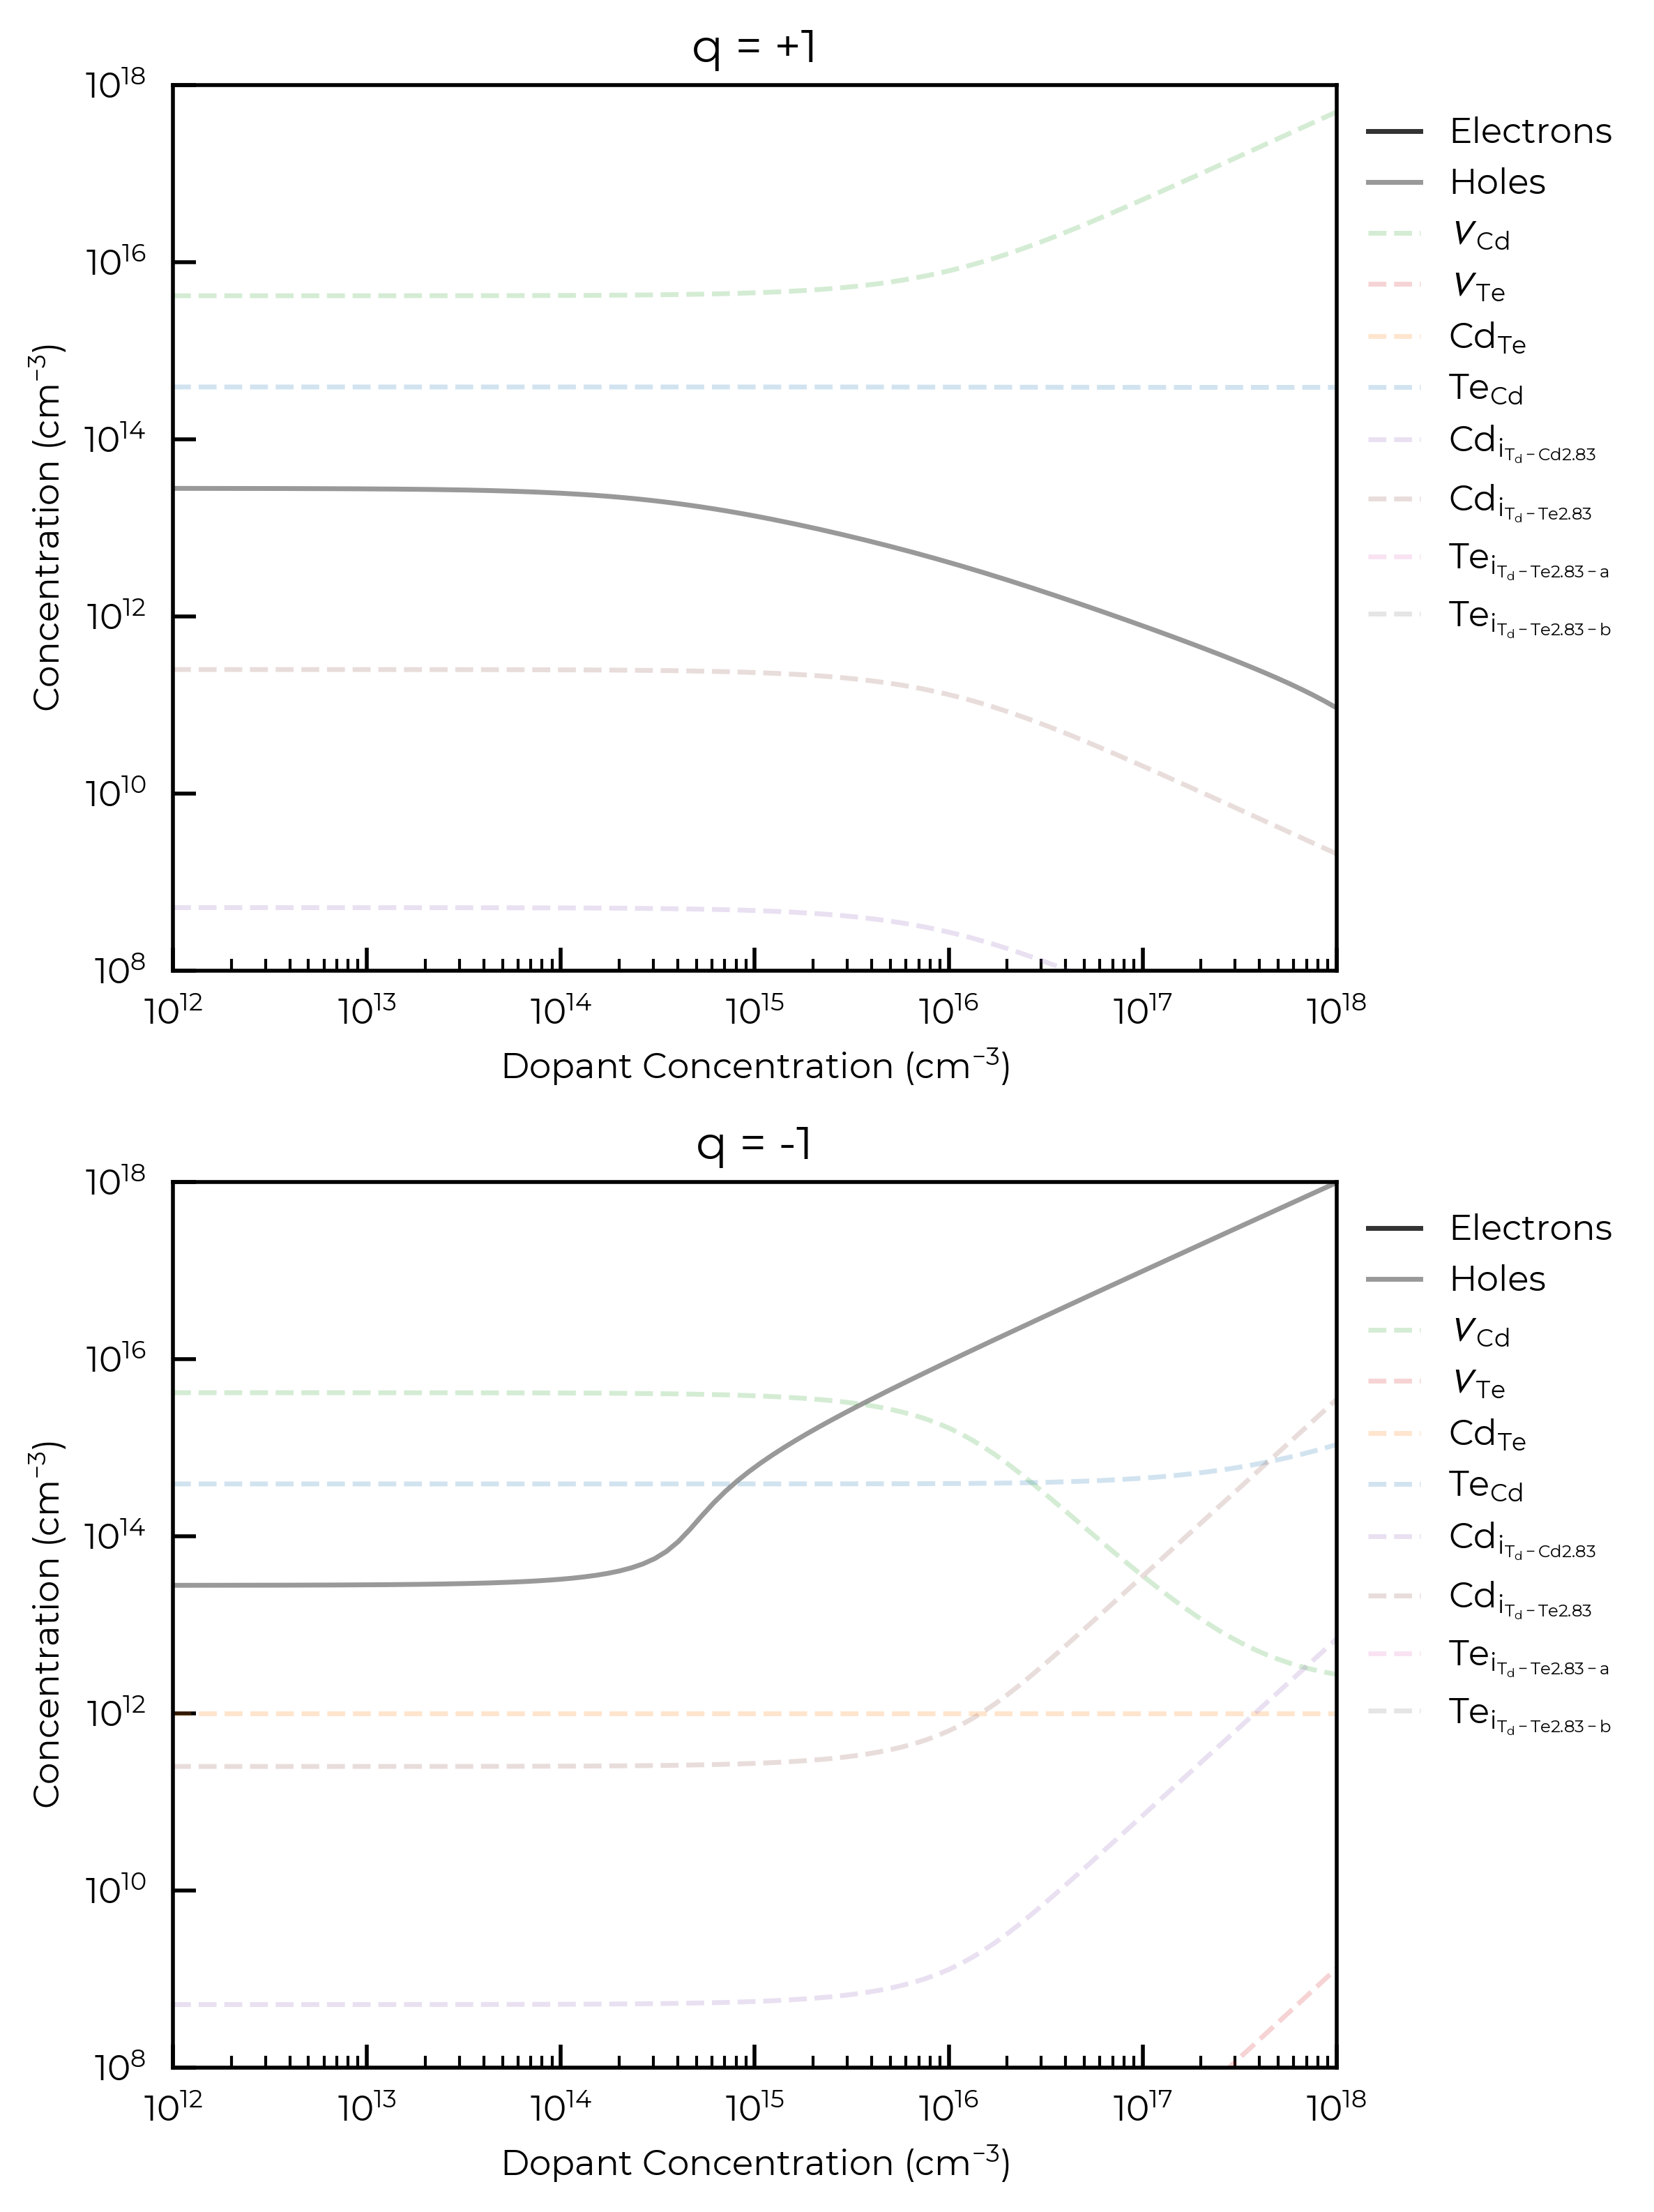

In [13]:
dopant_concentrations = np.logspace(12, 18, 100)
fig, ax = plt.subplots(2, 1, figsize=(6, 8))

dopant_df_positive = py_fs.scan_dopant_concentration(
    limit="Te-rich", annealing_temperature=900, quenched_temperature=300,
    effective_dopant_concentration_range=dopant_concentrations,
    free_defects = ["Te_i_Td_Te2.83", "v_Te"])
dopant_df_negative = py_fs.scan_dopant_concentration(
    limit="Te-rich", annealing_temperature=900, quenched_temperature=300,
    effective_dopant_concentration_range=-dopant_concentrations,
    free_defects = ["Te_i_Td_Te2.83", "v_Te"],
    fixed_defects = {"Cd_Te": (1e12)})

plot_dopant_carrier_concentrations(dopant_df_positive, dopant_df_negative, ax)
for defect in dopant_df_positive.index.unique():
    color = next(v for k,v in defect_colors.items() if k in defect)
    plot_dopant_data(ax[0], dopant_df_positive, dopant_concentrations, defect, color, ls="--")
    plot_dopant_data(ax[1], dopant_df_negative, dopant_concentrations, defect, color, ls="--")

ax[0].set_xlim(1e12, 1e18); ax[1].set_xlim(1e12, 1e18)
ax[0].set_ylim(1e8, 1e18); ax[1].set_ylim(1e8, 1e18)
ax[0].set_title(f"q = +1"); ax[1].set_title(f"q = -1")
plt.tight_layout()
plt.show()

As an additional, purely-illustrative example, the below code cell shows the case where vacancies and antisites are allowed to recombine upon cooling, while interstitials are kept fixed at their high temperature concentrations:  

100%|██████████| 100/100 [00:11<00:00,  8.88it/s]


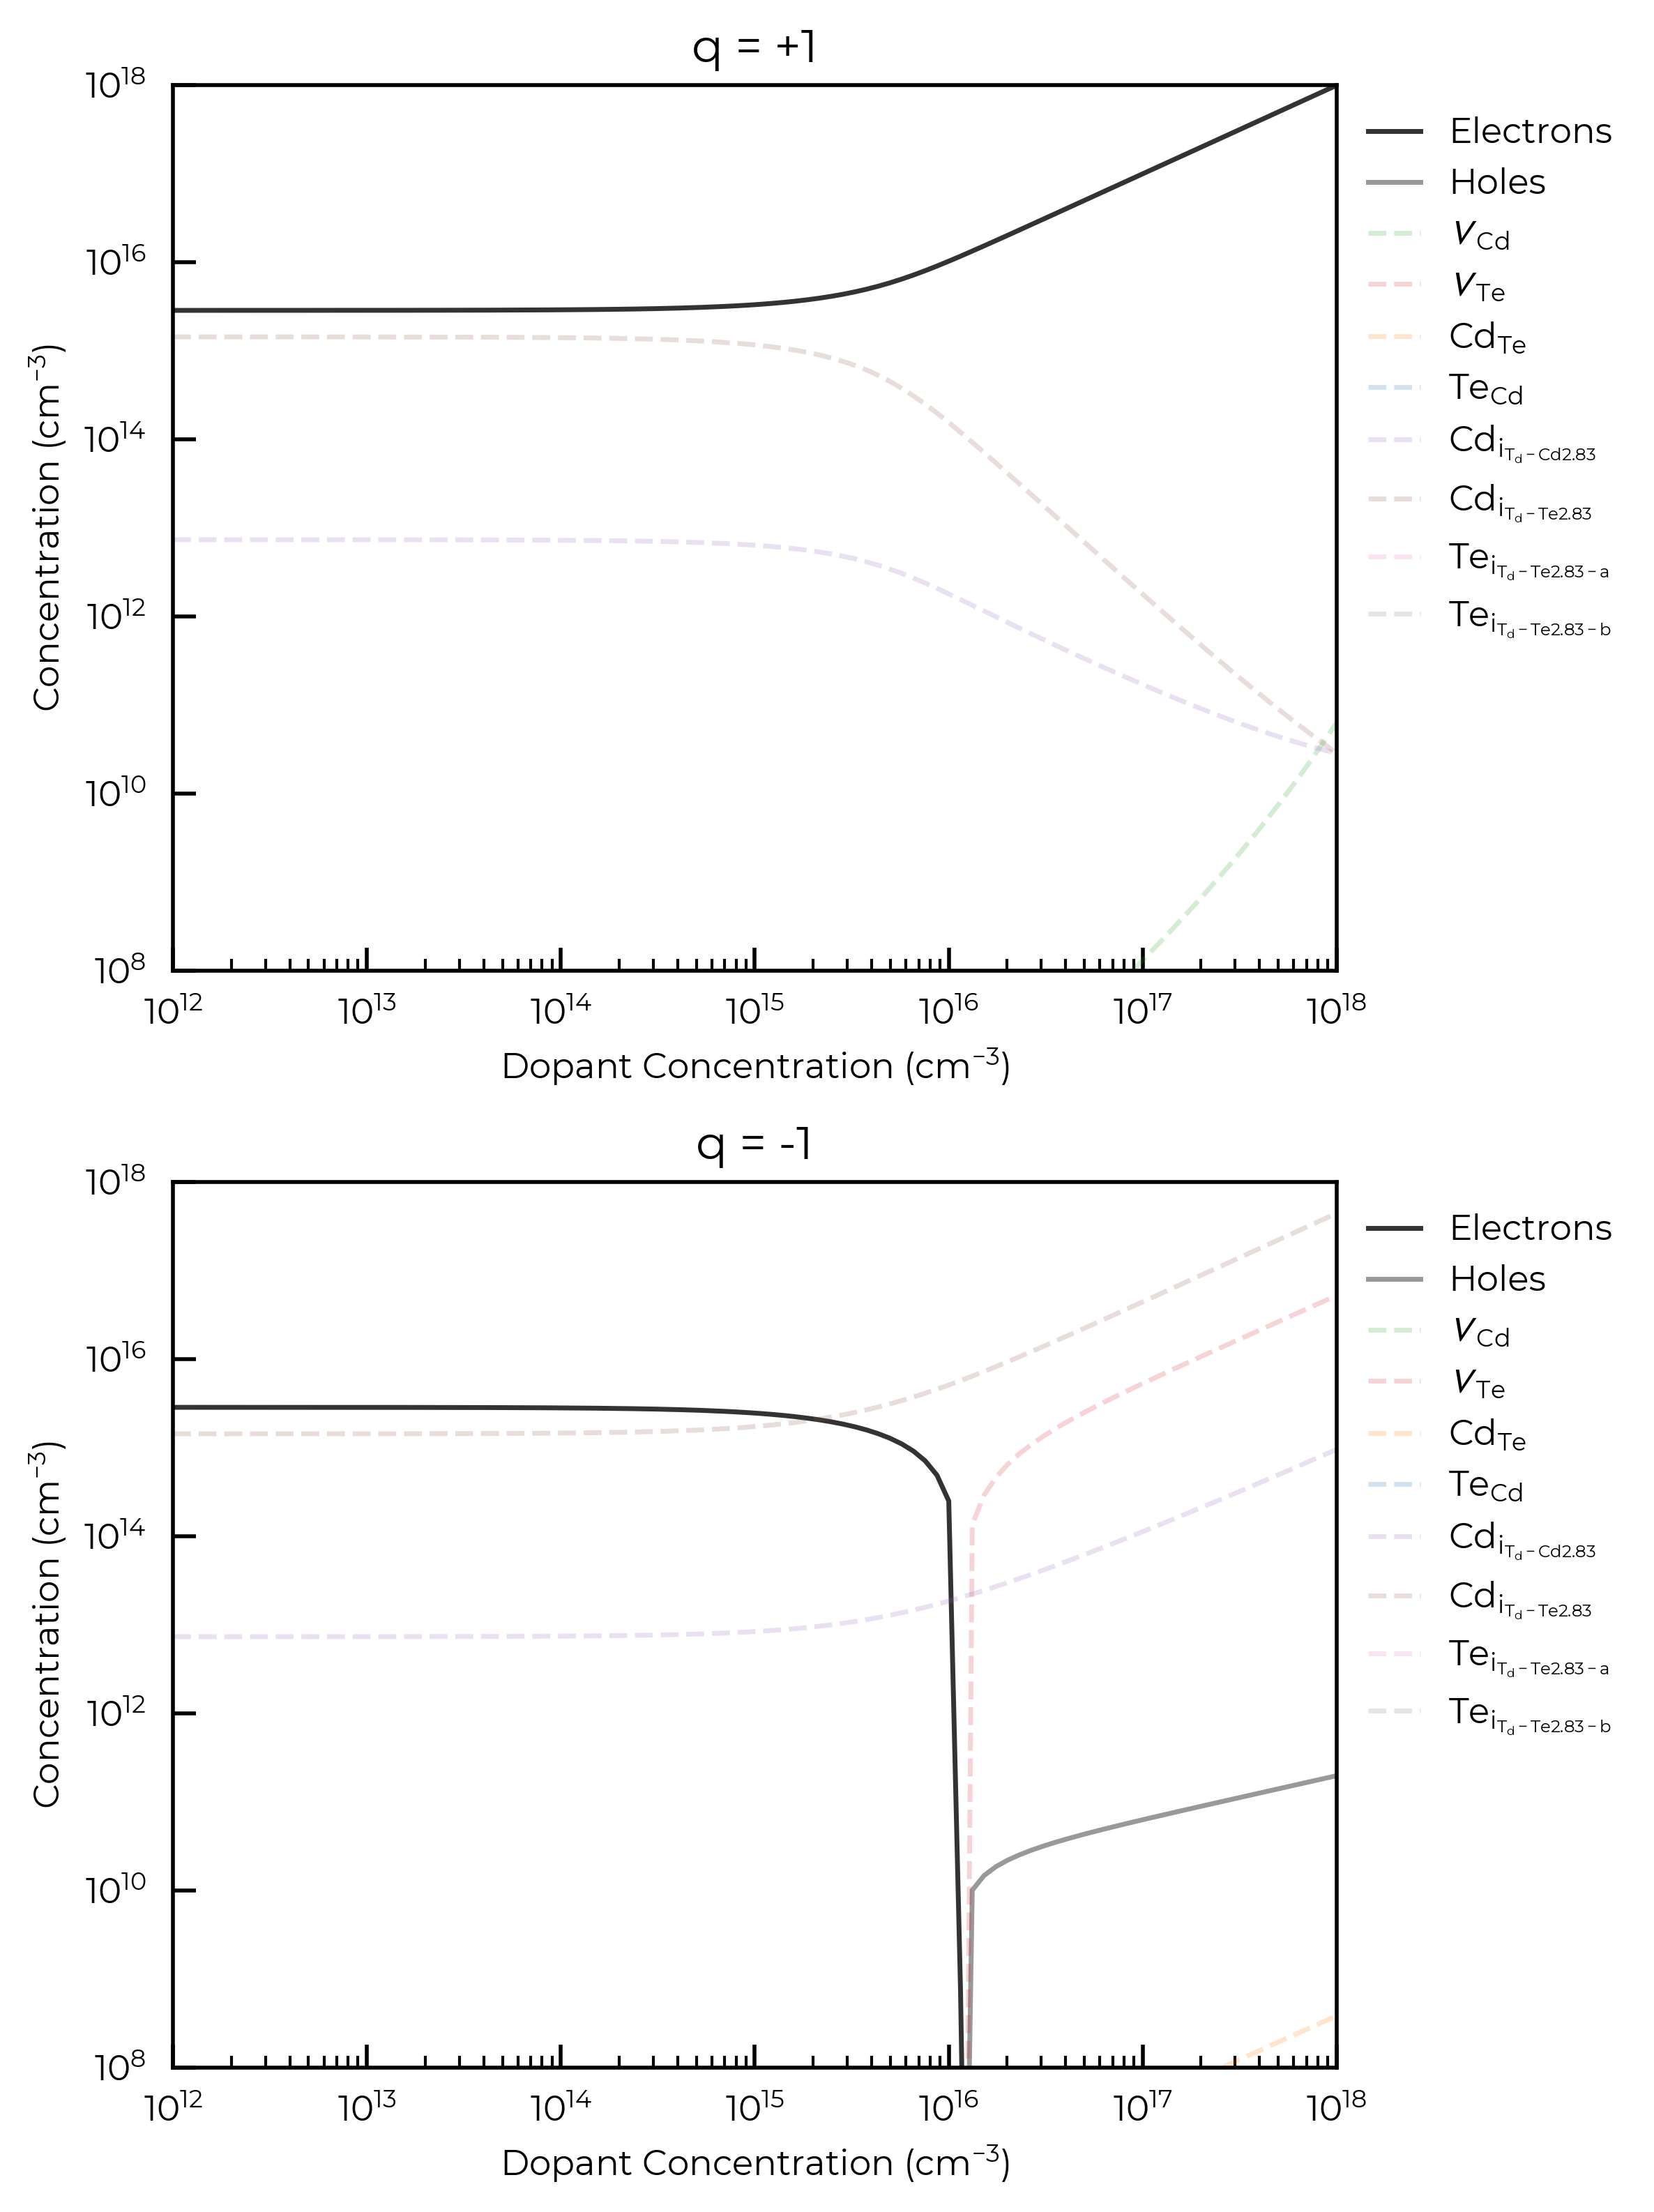

In [14]:
dopant_concentrations = np.logspace(12, 18, 100)
fig, ax = plt.subplots(2, 1, figsize=(6, 8))

dopant_df_positive = py_fs.scan_dopant_concentration(
    chempots=chempots["limits_wrt_el_refs"]["Cd-CdTe"], annealing_temperature=900, quenched_temperature=300, 
    effective_dopant_concentration_range=dopant_concentrations, 
    free_defects = ["Cd_Te", "v_Cd", "Te_Cd", "v_Te"])
dopant_df_negative = py_fs.scan_dopant_concentration(
    chempots=chempots["limits_wrt_el_refs"]["Cd-CdTe"], quenched_temperature=300, annealing_temperature=900, 
    effective_dopant_concentration_range=-dopant_concentrations, 
    free_defects = ["Cd_Te", "v_Cd", "Te_Cd", "v_Te"])

plot_dopant_carrier_concentrations(dopant_df_positive, dopant_df_negative, ax)
for defect in dopant_df_positive.index.unique():
    color = next(v for k,v in defect_colors.items() if k in defect)
    plot_dopant_data(ax[0], dopant_df_positive, dopant_concentrations, defect, color, ls="--")
    plot_dopant_data(ax[1], dopant_df_negative, dopant_concentrations, defect, color, ls="--")

ax[0].set_xlim(1e12, 1e18); ax[1].set_xlim(1e12, 1e18)
ax[0].set_ylim(1e8, 1e18); ax[1].set_ylim(1e8, 1e18)
ax[0].set_title(f"q = +1"); ax[1].set_title(f"q = -1")
plt.tight_layout()
plt.show()

Another thing that can be customized in the ensembles is the addition of a `fixed-defects` argument. This also requires the use of the `ps-sc-fermi` back end. While the example we provide below are purely illustrative, these calculations can be used as a way to simulate the effect of a fixed-concentration impurity. This can either be done as a fixed concentration of a particular defect, or defect charge state, as illustrated in the cell below.

100%|██████████| 23/23 [00:01<00:00, 18.57it/s]


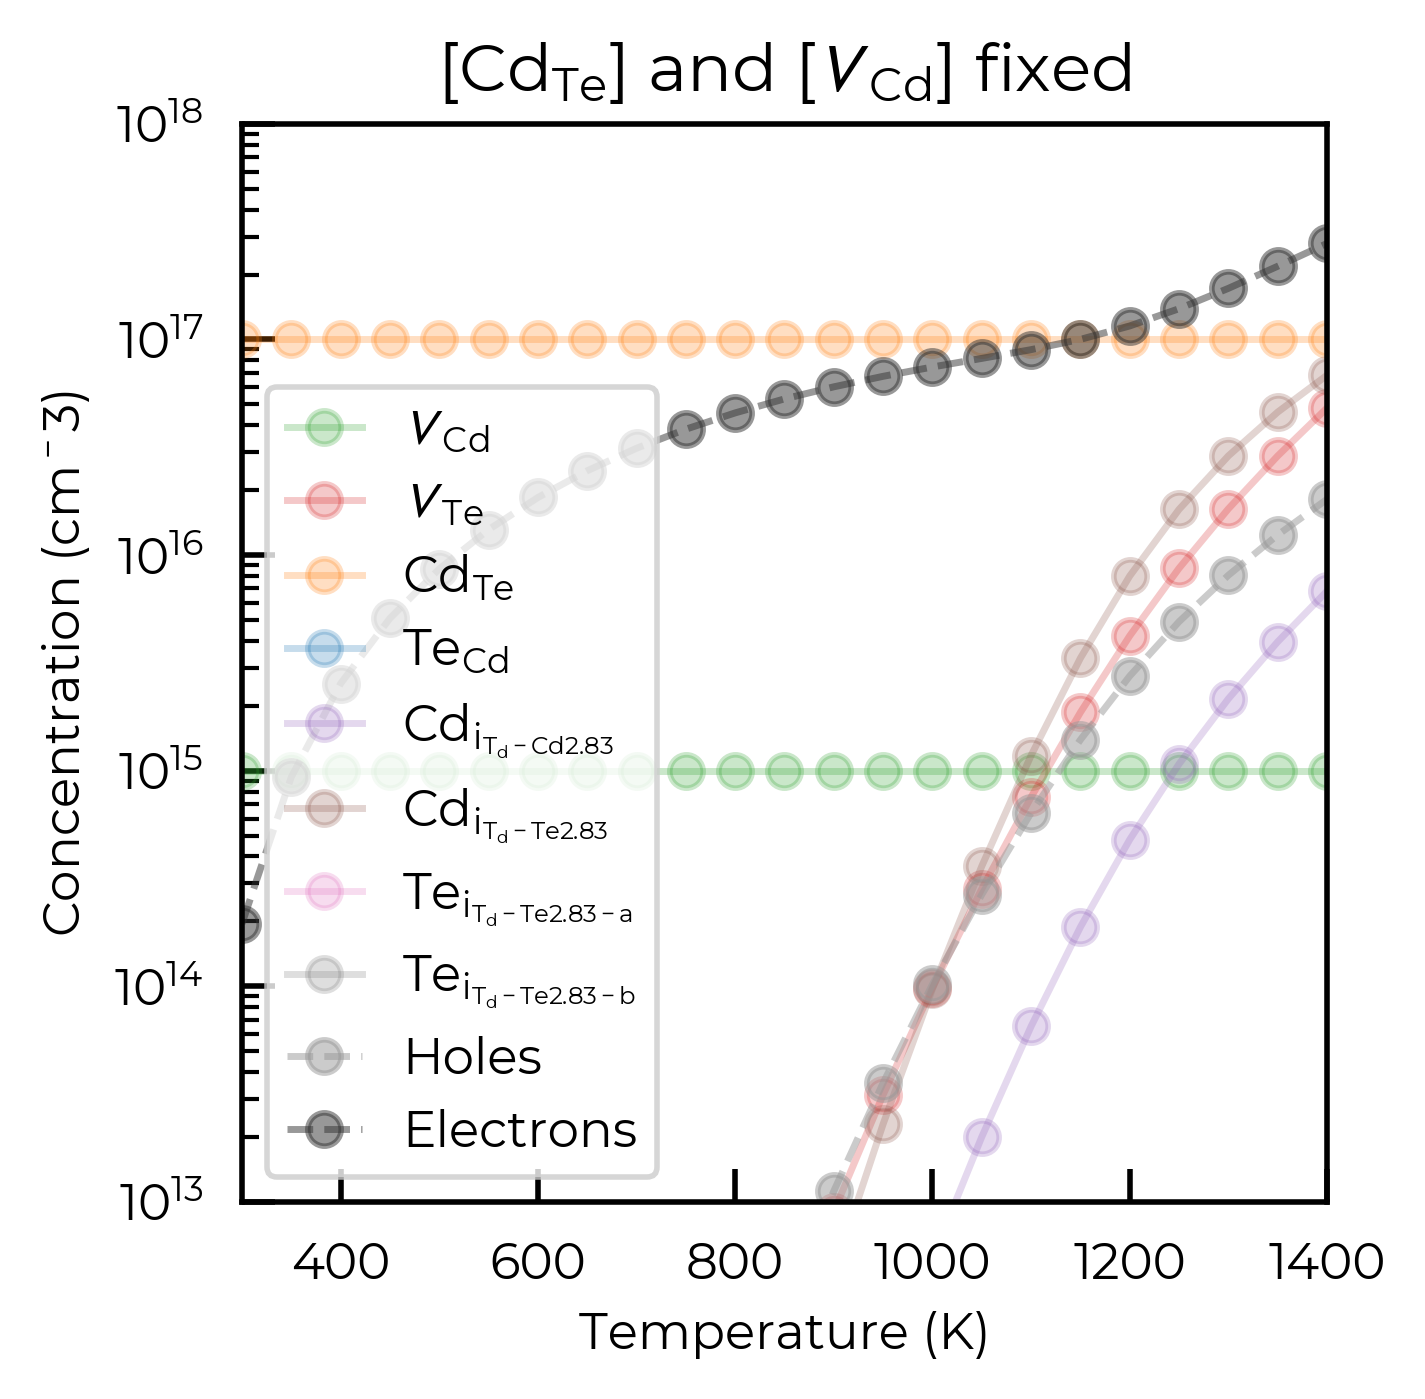

100%|██████████| 23/23 [00:01<00:00, 12.86it/s]


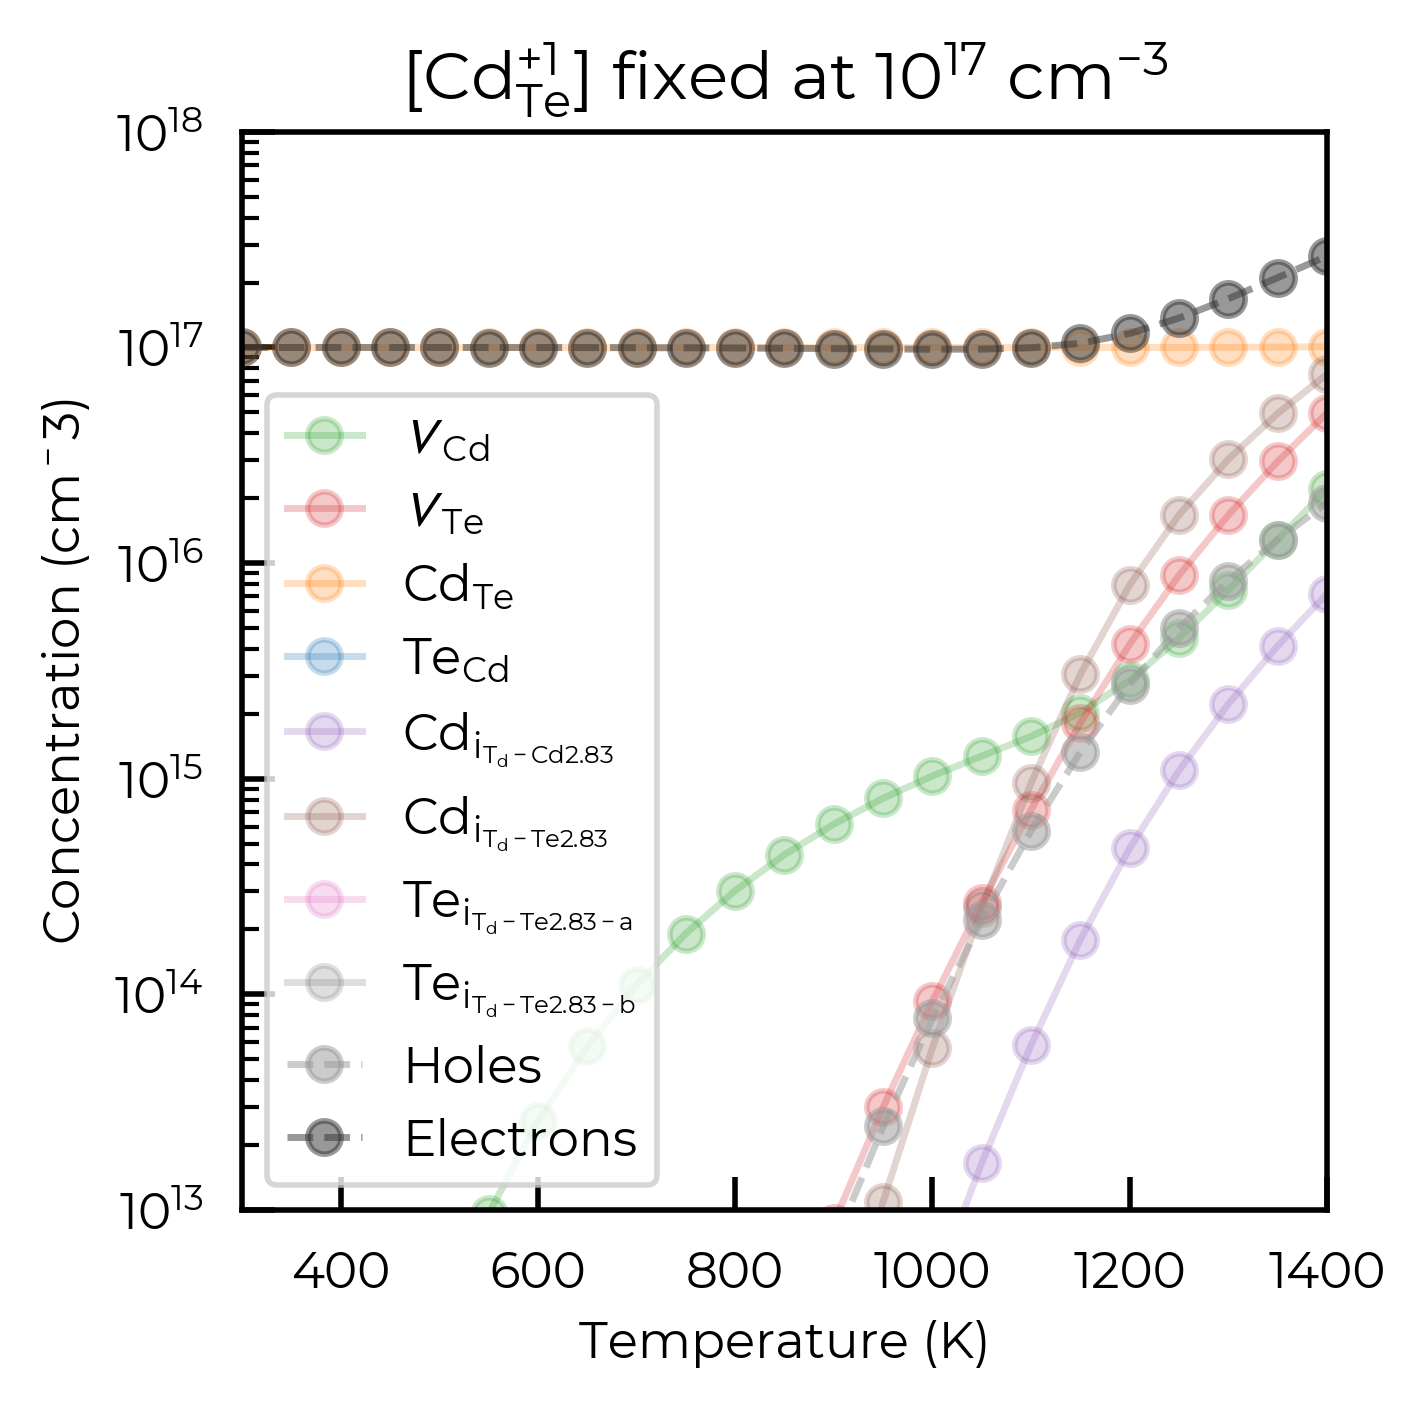

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from doped.utils.plotting import format_defect_name

# Define a range of temperatures to scan over (in Kelvin)
temperatures = range(300, 1410, 50)

# First plot: Scan temperature with fixed defects {"Cd_Te": 1e17, "v_Cd": 1e15}
temperature_df_py = py_fs.scan_temperature(
    chempots={'Cd': 0.0, 'Te': -1.2513},
    temperature_range=temperatures, 
    fixed_defects={"Cd_Te": 1e17, "v_Cd": 1e15}
)

# Create unique list of defects and plot concentrations
fig, ax = plt.subplots()

# Plot the hole and electron concentrations
def plot_carrier_concentrations(plot_data, ax):
    ax.plot(
        plot_data["Temperature (K)"], plot_data["Holes (cm^-3)"],
        marker="o", linestyle="--", color="#999999", alpha=0.5, label="Holes"
    )
    ax.plot(
        plot_data["Temperature (K)"], plot_data["Electrons (cm^-3)"],
        marker="o", linestyle="--", color="#333333", alpha=0.5, label="Electrons"
    )

def plot_temperature_df(temperature_df, ax):
    unique_defects = temperature_df.index.unique()
    for defect in unique_defects:
        plot_data = temperature_df.loc[defect]
        ax.plot(
            plot_data["Temperature (K)"],
            plot_data["Concentration (cm^-3)"],
            label=format_defect_name(defect, include_site_info_in_name=True, wout_charge=True),
            color=defect_colors.get(defect, "C7"),
            marker="o",
            alpha=0.25
        )
    plot_carrier_concentrations(plot_data, ax)

    # Set plot labels and scaling
    ax.set_xlabel("Temperature (K)"); ax.set_ylabel("Concentration (cm$^{-3}$)")
    ax.set_xlim(300, 1400); ax.set_ylim(1e13, 1e18)
    ax.set_yscale("log")
    ax.legend()

plot_temperature_df(temperature_df_py, ax)
plt.title(f"[{format_defect_name('Cd_Te', wout_charge=True)}] and [{format_defect_name('v_Cd', wout_charge=True)}] fixed")
plt.show()

# Second plot: Scan temperature with fixed defect {"Cd_Te_+1": 1e17}
temperature_df_py = py_fs.scan_temperature(
    chempots={'Cd': 0.0, 'Te': -1.2513},
    temperature_range=temperatures, 
    fixed_defects={"Cd_Te_+1": 1e17}
)

fig, ax = plt.subplots()
plot_temperature_df(temperature_df_py, ax)
plt.title(rf"[{format_defect_name('Cd_Te_+1')}] fixed at $10^{{{17}}}$ cm$^{{{-3}}}$")
plt.show()

## Cu<sub>2</sub>SiSe<sub>3</sub>: 2D Chemical Potential Scans

Another thing that has been added with the `FermiSolver` class is the ability to simply perform scans over >2d chemical potential spaces, this is outlined for Cu<sub>2</sub>SiSe<sub>3</sub> (a [potential solar absorber material](https://pubs.rsc.org/en/content/articlelanding/2023/ta/d3ta02429f)) in the cells below.

The defect formation energy diagram for this system (left = Cu-poor; right = Cu-rich):

<img src="https://pubs.rsc.org/image/article/2023/ta/d3ta02429f/d3ta02429f-f3_hi-res.gif"/>
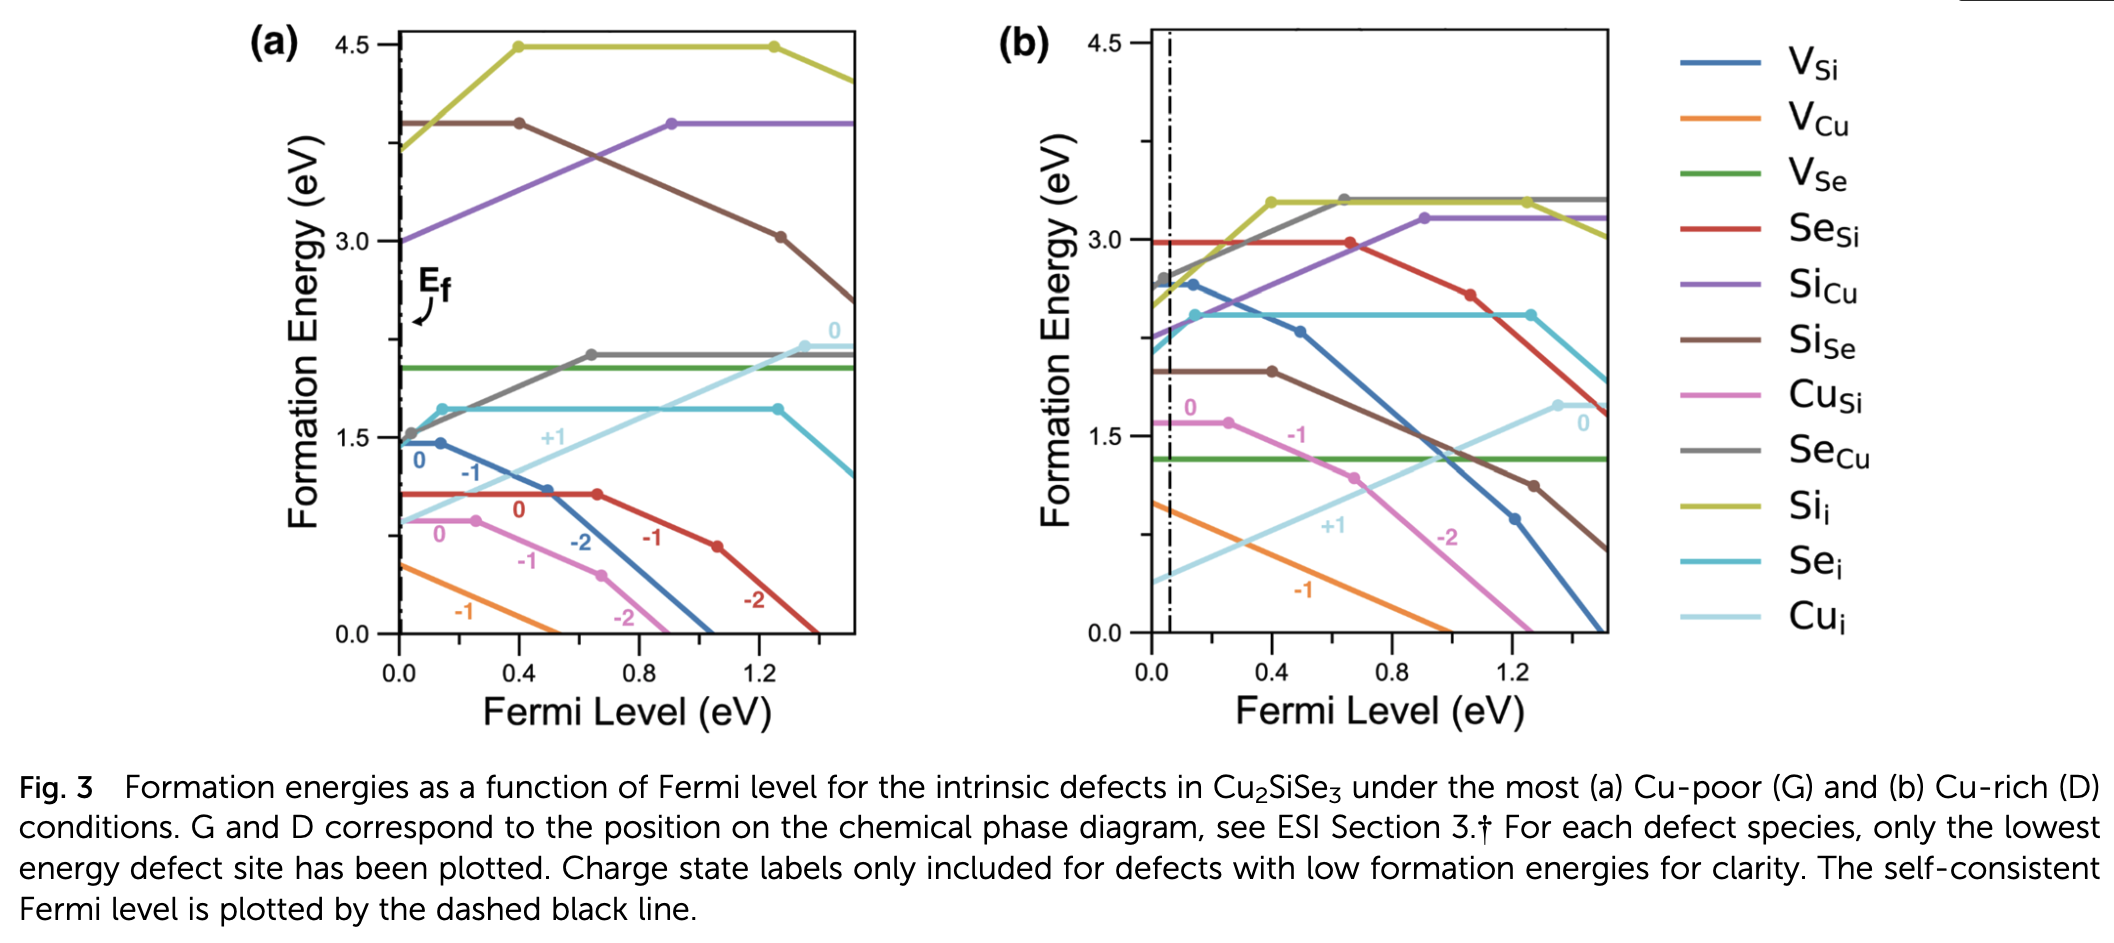

In [17]:
from monty.serialization import loadfn

# we need to specify the path to the vasprun.xml(.gz) file
# that was used for the DOS calculation. This is because
# we need to accurately account for the electronic carrier concentrations
# as well as the defect concentrations to determine the Fermi level
vasprun_path = "Cu2SiSe3/vasprun.xml.gz"

# the DefectThermodynamics object contains all the information about the
# defect formation energies and transition levels. It will underpin both the
# doped and py-sc-fermi solvers
defect_thermo = loadfn("Cu2SiSe3/Cu2SiSe3_thermo.json")

# In this case, our chempots have already been set as `DefectThermodynamics.chempots`,
# so we don't need to reload/set them, but if we wanted to, we could do so with:
# chempots = loadfn("Cu2SiSe3/Cu2SiSe3_chempots.json")
# defect_thermo.chempots = chempots

fs = FermiSolver(defect_thermodynamics=defect_thermo, bulk_dos=vasprun_path)
data = fs.scan_chemical_potential_grid(
    n_points=50,  # n_points in each dimension when scanning over the chemical potential grid
    annealing_temperature=1000, # the temperature at which to anneal the system
    quenched_temperature=300,  # the temperature at which to quench the system
)

100%|██████████| 957/957 [00:39<00:00, 24.07it/s]


This can then be used to plot a variable of interest over the calculated points.

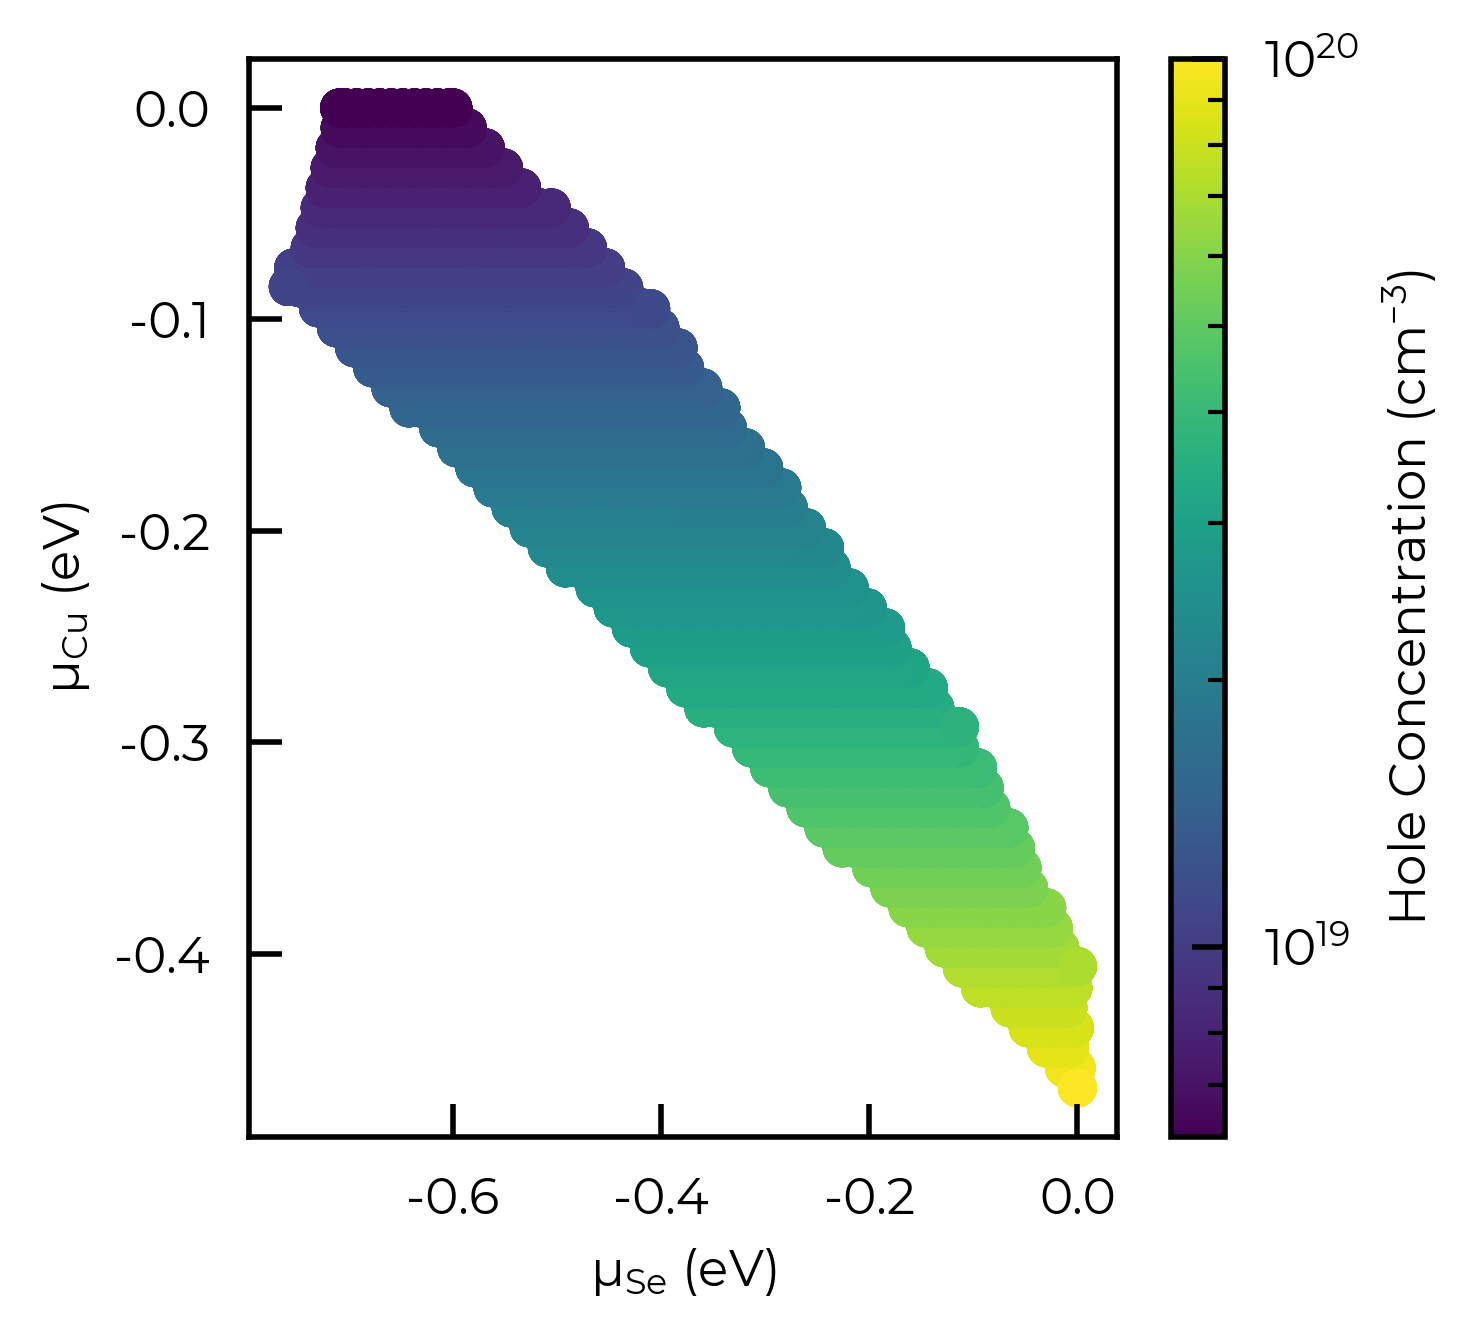

In [18]:
from matplotlib.colors import LogNorm

hole_concs = data["Holes (cm^-3)"]
plt.scatter(data["μ_Se (eV)"], data["μ_Cu (eV)"], c=hole_concs, cmap='viridis',
            norm=LogNorm(min(hole_concs), 10**round(np.log10(max(hole_concs))))  # set upper limit to next order of magnitude for clearer colourbar here
)
cbar = plt.colorbar(label="Hole Concentration (cm$^{-3}$)")

plt.xlabel("$\mu_{Se}$ (eV)"); plt.ylabel("$\mu_{Cu}$ (eV)")
plt.show()

As a smooth heatmap:

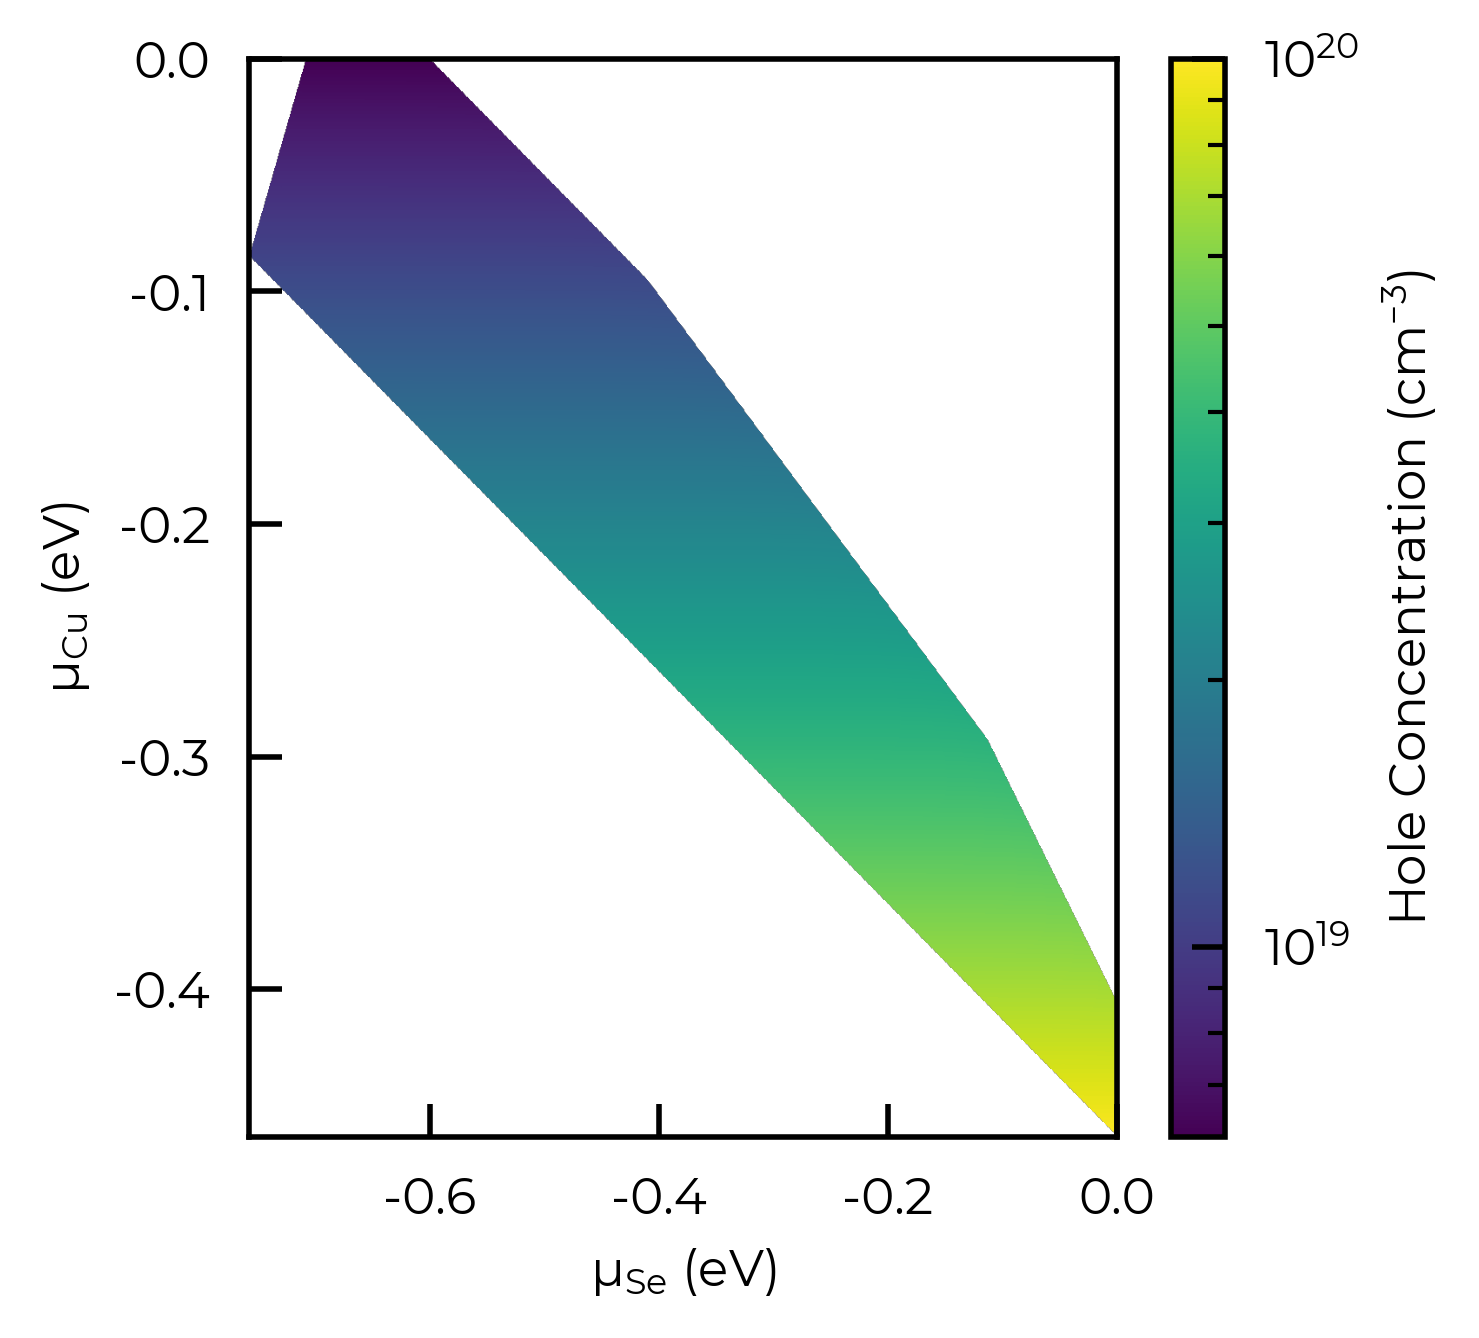

In [20]:
import numpy as np
from scipy.interpolate import griddata

f, ax = plt.subplots()
x = np.linspace(data["μ_Se (eV)"].min(), data["μ_Se (eV)"].max(), 1000)
y = np.linspace(data["μ_Cu (eV)"].min(), data["μ_Cu (eV)"].max(), 1000)
X, Y = np.meshgrid(x, y)

# Interpolate:
Z = griddata((data["μ_Se (eV)"], data["μ_Cu (eV)"]), data["Holes (cm^-3)"], (X, Y), method='cubic')
im = ax.imshow(Z, extent=(data["μ_Se (eV)"].min(), data["μ_Se (eV)"].max(), data["μ_Cu (eV)"].min(), data["μ_Cu (eV)"].max()),
               origin='lower', cmap='viridis', aspect="auto",
               norm=LogNorm(min(data["Holes (cm^-3)"]), 10**round(np.log10(max(data["Holes (cm^-3)"])))))
f.colorbar(im, label="Hole Concentration (cm$^{-3}$)")
ax.set_xlabel("$\mu_{Se}$ (eV)"); ax.set_ylabel("$\mu_{Cu}$ (eV)")
ax.set_xlim(ax.get_xlim()[0], 0)  # ensure x-axis extends to 0
plt.show()

As expected, here we see the hole concentration primarily correlates with the Cu chemical potential, due to the fact that $V$<sub>Cu</sub> is the dominant acceptor species in this system (see formation energy diagram above), and so lower Cu chemical potentials (more Cu-poor conditions) favour higher copper vacancy and thus hole concentrations.

In these final cells, we show a tool for investigating complex chemical potential spaces. For a target value (hole, electron, or a specific defect concentration, or the Fermi energy) we find the position in chemical potential space where that target value is minimised or maximised. This is done by carrying out a coarse interpolation in chemical potential space, and finding an initial point at which the target value is minimised or maximised. A new chemical potential grid is then generated centered on this new value and the search repeated. This is done until the change in the target value is smaller than a provided tolerance factor. The output of the code is a dataframe that describes the defect system at the identified chemical potential. Example useage is shown in the cell below

In [21]:
max_holes_df = fs.optimise(
    target="Holes (cm^-3)",  # the target variable
    min_or_max="max",  # whether to find the minimum or maximum of the target variable
    tolerance=0.001, # the convergence tolerance for the target variable, in relative magnitude
    annealing_temperature=1000, 
    quenched_temperature=300)
max_holes_df

100%|██████████| 39/39 [00:01<00:00, 21.83it/s]


Searching for chemical potentials which maximise the target column: ['Holes (cm^-3)']...


100%|██████████| 39/39 [00:01<00:00, 24.16it/s]


Concentration (cm^-3)  Annealing Temperature (K)  \
Defect                                                     
v_Cu_1           9.918464e+19                       1000   
v_Si             8.812211e+14                       1000   
v_Se             4.554869e+11                       1000   
Cu_Si            7.536802e+17                       1000   
Si_Cu            2.095310e+06                       1000   
Si_Se            1.828131e+02                       1000   
Se_Cu            1.259815e+14                       1000   
Se_Si            3.275868e+16                       1000   
Int_Cu           1.287555e+17                       1000   
Int_Si           1.931946e+02                       1000   
Int_Se           5.145858e+13                       1000   

        Quenched Temperature (K)  Fermi Level (eV wrt VBM)  Electrons (cm^-3)  \
Defect                                                                          
v_Cu_1                       300                 -0.074357       2.704418e-10   
v_Si                         300                 -0.074357       2.704418e-10   
v_Se                         300                 -0.074357       2.704418e-10   
Cu_Si                        300                 -0.074357       2.704418e-10   
Si_Cu                        300                 -0.074357       2.704418e-10   
Si_Se                        300                 -0.074357       2.704418e-10   
Se_Cu                        300                 -0.074357       2.704418e-10   
Se_Si                        300                 -0.074357       2.704418e-10   
Int_Cu                       300                 -0.074357       2.704418e-10   
Int_Si                       300                 -0.074357       2.704418e-10   
Int_Se                       300                 -0.074357       2.704418e-10   

        Holes (cm^-3)  μ_Cu (eV)  μ_Si (eV)  μ_Se (eV)  
Defect                                                  
v_Cu_1   9.905554e+19  -0.463558  -1.594069        0.0  
v_Si     9.905554e+19  -0.463558  -1.594069        0.0  
v_Se     9.905554e+19  -0.463558  -1.594069        0.0  
Cu_Si    9.905554e+19  -0.463558  -1.594069        0.0  
Si_Cu    9.905554e+19  -0.463558  -1.594069        0.0  
Si_Se    9.905554e+19  -0.463558  -1.594069        0.0  
Se_Cu    9.905554e+19  -0.463558  -1.594069        0.0  
Se_Si    9.905554e+19  -0.463558  -1.594069        0.0  
Int_Cu   9.905554e+19  -0.463558  -1.594069        0.0  
Int_Si   9.905554e+19  -0.463558  -1.594069        0.0  
Int_Se   9.905554e+19  -0.463558  -1.594069        0.0

As expected, we see our target variable (the hole concentration here) is maximised for low copper chemical potentials (μ<sub>Cu</sub> = -0.46 eV) which corresponds to copper-poor conditions.

```{tip}
Note that the ``delta_gap`` argument used in ``DefectThermodynamics`` methods is not directly supported in this class. If band gap modulation is desired, it is recommended to use the ``DefectThermodynamics`` methods directly with ``delta_gap`` as shown in the (advanced) defect thermodynamics tutorials.
```